In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import sys
sys.path.append('/content/drive/MyDrive')
import helper as hp

# **Softmax Regression**

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
from keras.models import Sequential
from keras import regularizers
from keras.layers import Dense, BatchNormalization, Dropout, Flatten, Activation
from keras.optimizers import Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax, Nadam
from keras.metrics import SensitivityAtSpecificity
from keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping, Callback
from keras.utils import np_utils
import keras.backend as K
import datetime

from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc, roc_auc_score
from itertools import cycle


In [5]:
from keras.datasets import fashion_mnist
(x_data, y_data), (x_test, y_test) = fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal',      'Shirt',   'Sneaker',  'Bag',   'Ankle boot']

# 20% del dataset para validación
validation = 0.20
N_validation_split = int(x_data.shape[0]*(1-validation))
# Training Set
x_train = x_data[:N_validation_split]
y_train = y_data[:N_validation_split]

# Cross Validation Set
x_val = x_data[N_validation_split:]
y_val = y_data[N_validation_split:]

# Data normalization
x_train = x_train.astype('float32') / 255
x_val = x_val.astype('float32') / 255
x_test = x_test.astype('float32') / 255



4422102/4422102 [==============================] - 0s 0us/step


### Sparse arrays

In [6]:
y_sparse_train = np.zeros([len(y_train),10])
y_sparse_test = np.zeros([len(y_test),10])
for idx in range(len(y_train)):
    y_sparse_train[idx,y_train[idx]] = 1

for idx in range(len(y_test)):
    y_sparse_test[idx,y_test[idx]] = 1

### One hot encoding

In [7]:
y_train_categorical = np_utils.to_categorical(y_train)
y_val_categorical = np_utils.to_categorical(y_val)
print(y_train_categorical.shape)
for i in range(10):
    print(y_train[i], y_train_categorical[i])

(48000, 10)
9 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
3 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
0 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
7 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
2 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
5 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


### Softmax regression:

In [8]:
import helper as hp

In [9]:
K.clear_session()
model_softmax = hp.classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 0,
                                    hidden_layers_units = [0],
                                    hidden_activation = 'sigmoid',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = 0.0,
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=False,
                                    lr = 0.001,
                                    decay = 0,
                                    out_softmax = True,
                                    optimizer = Adam)
model_softmax.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 Output (Dense)              (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


### Accuracy of model previous to training

In [10]:
score = model_softmax.evaluate(x_val, y_val_categorical, verbose=0)
print("loss: ", score[0])
print("accuracy: ", score[1])

loss:  2.5311927795410156
accuracy:  0.11516666412353516


### Let's train (compile) this model:
This model has an early stopping callback.

In [11]:
model_trained = model_softmax.fit(x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=128,
                                  verbose=1,
                                  validation_data = (x_val, y_val_categorical),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )

Epoch 1/512
375/375 [==============================] - 3s 6ms/step - loss: 0.7920 - accuracy: 0.7429 - f1_m: 0.6654 - precision_m: 0.8502 - recall_m: 0.5688 - val_loss: 0.5760 - val_accuracy: 0.8073 - val_f1_m: 0.7873 - val_precision_m: 0.8742 - val_recall_m: 0.7166
Epoch 2/512
375/375 [==============================] - 1s 4ms/step - loss: 0.5384 - accuracy: 0.8215 - f1_m: 0.8052 - precision_m: 0.8799 - recall_m: 0.7428 - val_loss: 0.5066 - val_accuracy: 0.8278 - val_f1_m: 0.8168 - val_precision_m: 0.8841 - val_recall_m: 0.7595
Epoch 3/512
375/375 [==============================] - 1s 4ms/step - loss: 0.4902 - accuracy: 0.8365 - f1_m: 0.8266 - precision_m: 0.8854 - recall_m: 0.7756 - val_loss: 0.4807 - val_accuracy: 0.8368 - val_f1_m: 0.8284 - val_precision_m: 0.8839 - val_recall_m: 0.7798
Epoch 4/512
375/375 [==============================] - 1s 3ms/step - loss: 0.4645 - accuracy: 0.8436 - f1_m: 0.8371 - precision_m: 0.8882 - recall_m: 0.7919 - val_loss: 0.4666 - val_accuracy: 0.8412 

### **Metrics!**

313/313 [==============================] - 0s 1ms/step
Softmax Regression:
  Accuracy: 0.859416663646698
  Loss: 0.40799960494041443
  Precision: 0.8886893391609192
  Recall: 0.8307569026947021
  F1-score: 0.8586341142654419
  ROC AUC: 0.9836737222222223


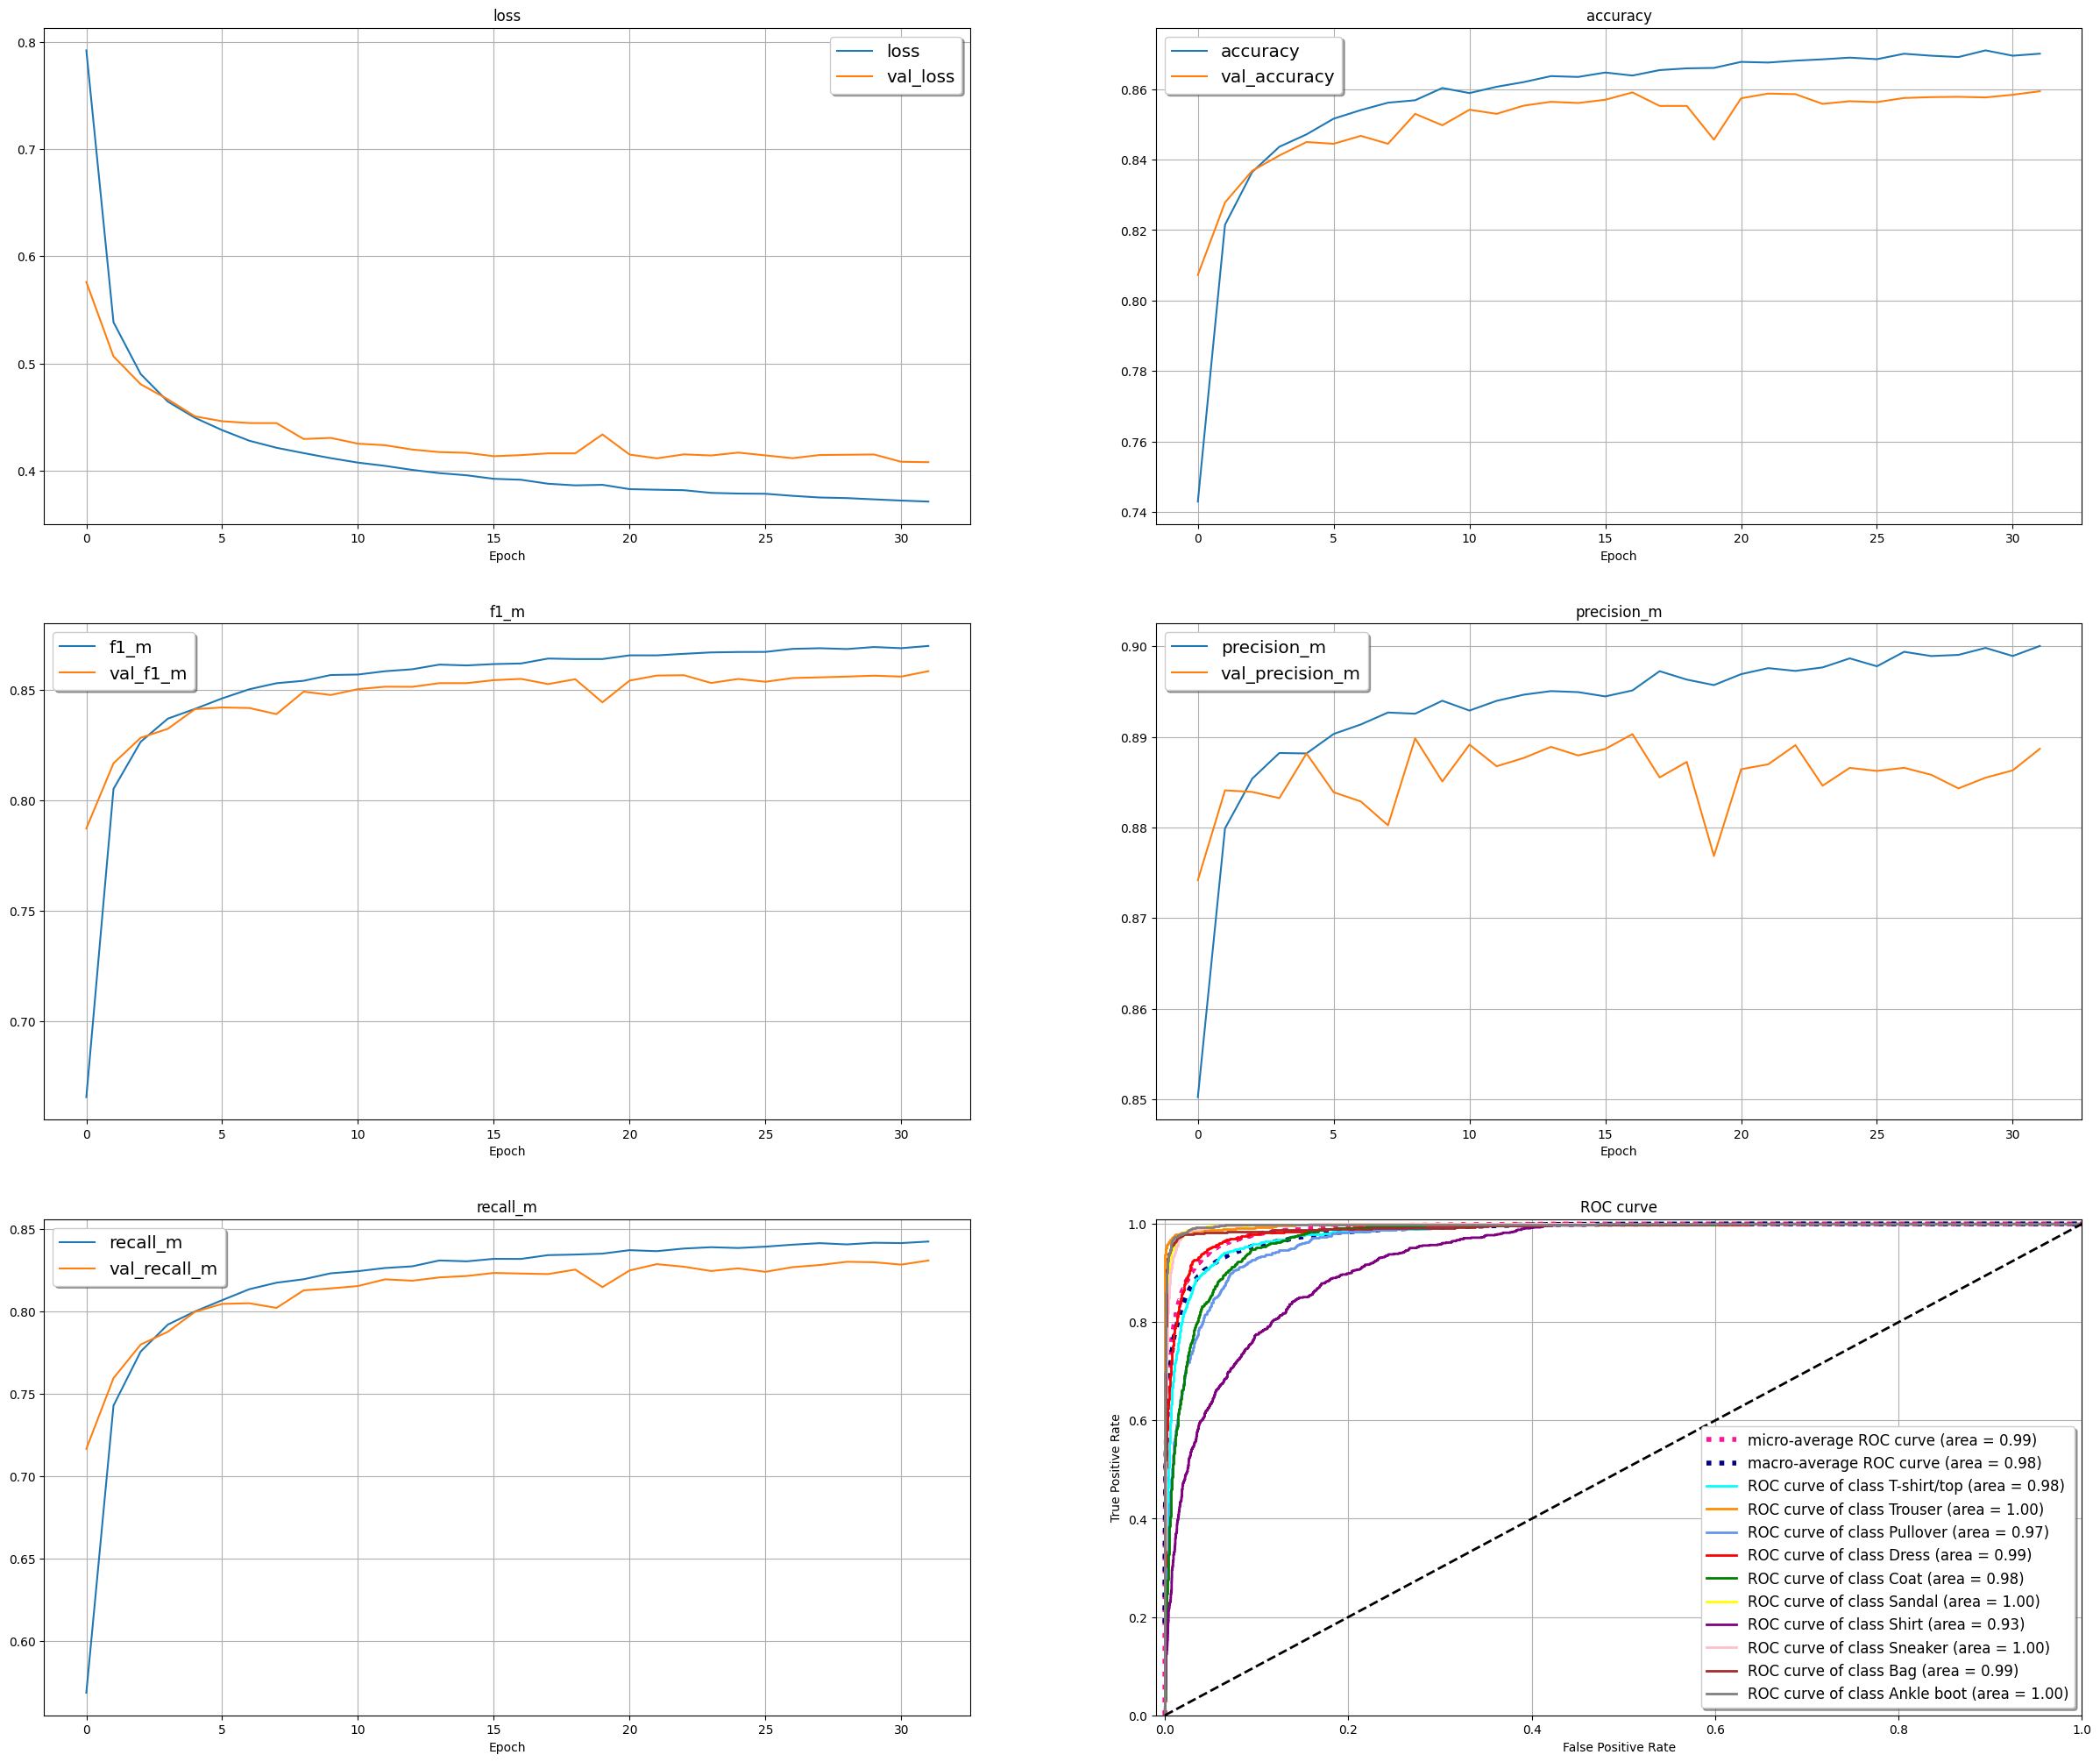

In [12]:
y_pred= model_softmax.predict(x_test)

# Print the evaluation metrics
print("Softmax Regression:")
print("  Accuracy:", model_trained.history['val_accuracy'][-1])
print("  Loss:", model_trained.history['val_loss'][-1])
print("  Precision:", model_trained.history['val_precision_m'][-1])
print("  Recall:", model_trained.history['val_recall_m'][-1])
print("  F1-score:", model_trained.history['val_f1_m'][-1])
print("  ROC AUC:", roc_auc_score(y_sparse_test, y_pred, multi_class='ovr', average="macro"))


metrics = [[['loss', "loss"],['val_loss',"val_loss"]],
            [['accuracy', "accuracy"],['val_accuracy', "val_accuracy"]],
            [['f1_m', "f1_m"],['val_f1_m', "val_f1_m"]],
            [['precision_m', "precision_m"],['val_precision_m', "val_precision_m"]],
            [['recall_m', "recall_m"],['val_recall_m', "val_recall_m"]],
            [['', ""],['', ""]]]

f, axis = plt.subplots(3, 2, figsize=(30, 25))
k = 0
for i in range(3):
    for j in range(2):
        if(k < 5):
            axis[i,j].plot(model_trained.history[metrics[k][0][0]], label = metrics[k][0][1])
            axis[i,j].plot(model_trained.history[metrics[k][1][0]], label = metrics[k][1][1])
            axis[i,j].grid()
            axis[i,j].set_xlabel('Epoch')
            axis[i,j].legend(shadow=True, fontsize='x-large')
            axis[i,j].set_title(metrics[k][0][1])
        else:
            lw=2
            fpr, tpr, roc_auc = hp.plot_ROC(y_sparse_test, y_pred, class_names)
            axis[i,j].plot(fpr["micro"], tpr["micro"],
                        label='micro-average ROC curve (area = {0:0.2f})'
                            ''.format(roc_auc["micro"]),
                        color='deeppink', linestyle=':', linewidth=4)

            axis[i,j].plot(fpr["macro"], tpr["macro"],
                        label='macro-average ROC curve (area = {0:0.2f})'
                            ''.format(roc_auc["macro"]),
                        color='navy', linestyle=':', linewidth=4)

            colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'red', 'green', 'yellow', 'purple', 'pink', 'brown', 'gray'])
            for h, color in zip(range(len(class_names)), colors):
                axis[i,j].plot(fpr[h], tpr[h], color=color, lw=lw,
                            label='ROC curve of class {0} (area = {1:0.2f})'
                            ''.format(class_names[h], roc_auc[h]))

            axis[i,j].plot([0, 1], [0, 1], 'k--', lw=lw)
            axis[i,j].set_xlim([-0.01, 1.0])
            axis[i,j].set_ylim([0.0, 1.01])
            axis[i,j].set_xlabel('False Positive Rate')
            axis[i,j].set_ylabel('True Positive Rate')
            axis[i,j].set_title('ROC curve')
            axis[i,j].grid()
            axis[i,j].legend(loc="lower right", shadow=True, fontsize='large')
        k += 1



There is overfitting as we see in the Accuracy metric although it does not seem awful. We will see that ""coincidentally"" some of the parameters used are the optimal ones.

**Micro-average** "takes imbalance into account" in the sense that the resulting performance is based on the proportion of every class, i.e. the performance of a large class has more impact on the result than of a small class.
**Macro-average** "doesn't take imbalance into account" in the sense that the resulting performance is a simple average over the classes, so every class is given equal weight independently from their proportion.

https://datascience.stackexchange.com/questions/85981/micro-average-vs-macro-average-for-class-imbalance

**As we have uniformly distributed classes, we will use the macro-average for computing the ROC curve.**

### Optimizers:


In [90]:
optimizers = [Adam, RMSprop, SGD, Adagrad, Adadelta, Adamax, Nadam]

accuracies_o = []
losses_o = []
histories_o = []
for o in optimizers:
    K.clear_session()
    model_o = hp.classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 0,
                                    hidden_layers_units = [0],
                                    hidden_activation = 'sigmoid',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = 0.0,
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=False,
                                    lr = 0.001,
                                    decay = 0,
                                    out_softmax = True,
                                    optimizer = o)
    model_trained_o = model_o.fit(    x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=128,
                                  verbose=0,
                                  validation_data = (x_val, y_val_categorical),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )
    accuracies_o.append(model_trained_o.history['val_accuracy'])
    losses_o.append(model_trained_o.history['val_loss'])
    histories_o.append(model_trained_o.history)

Epoch 31: early stopping
Epoch 31: early stopping
Epoch 141: early stopping
Epoch 128: early stopping
Epoch 358: early stopping
Epoch 40: early stopping
Epoch 37: early stopping


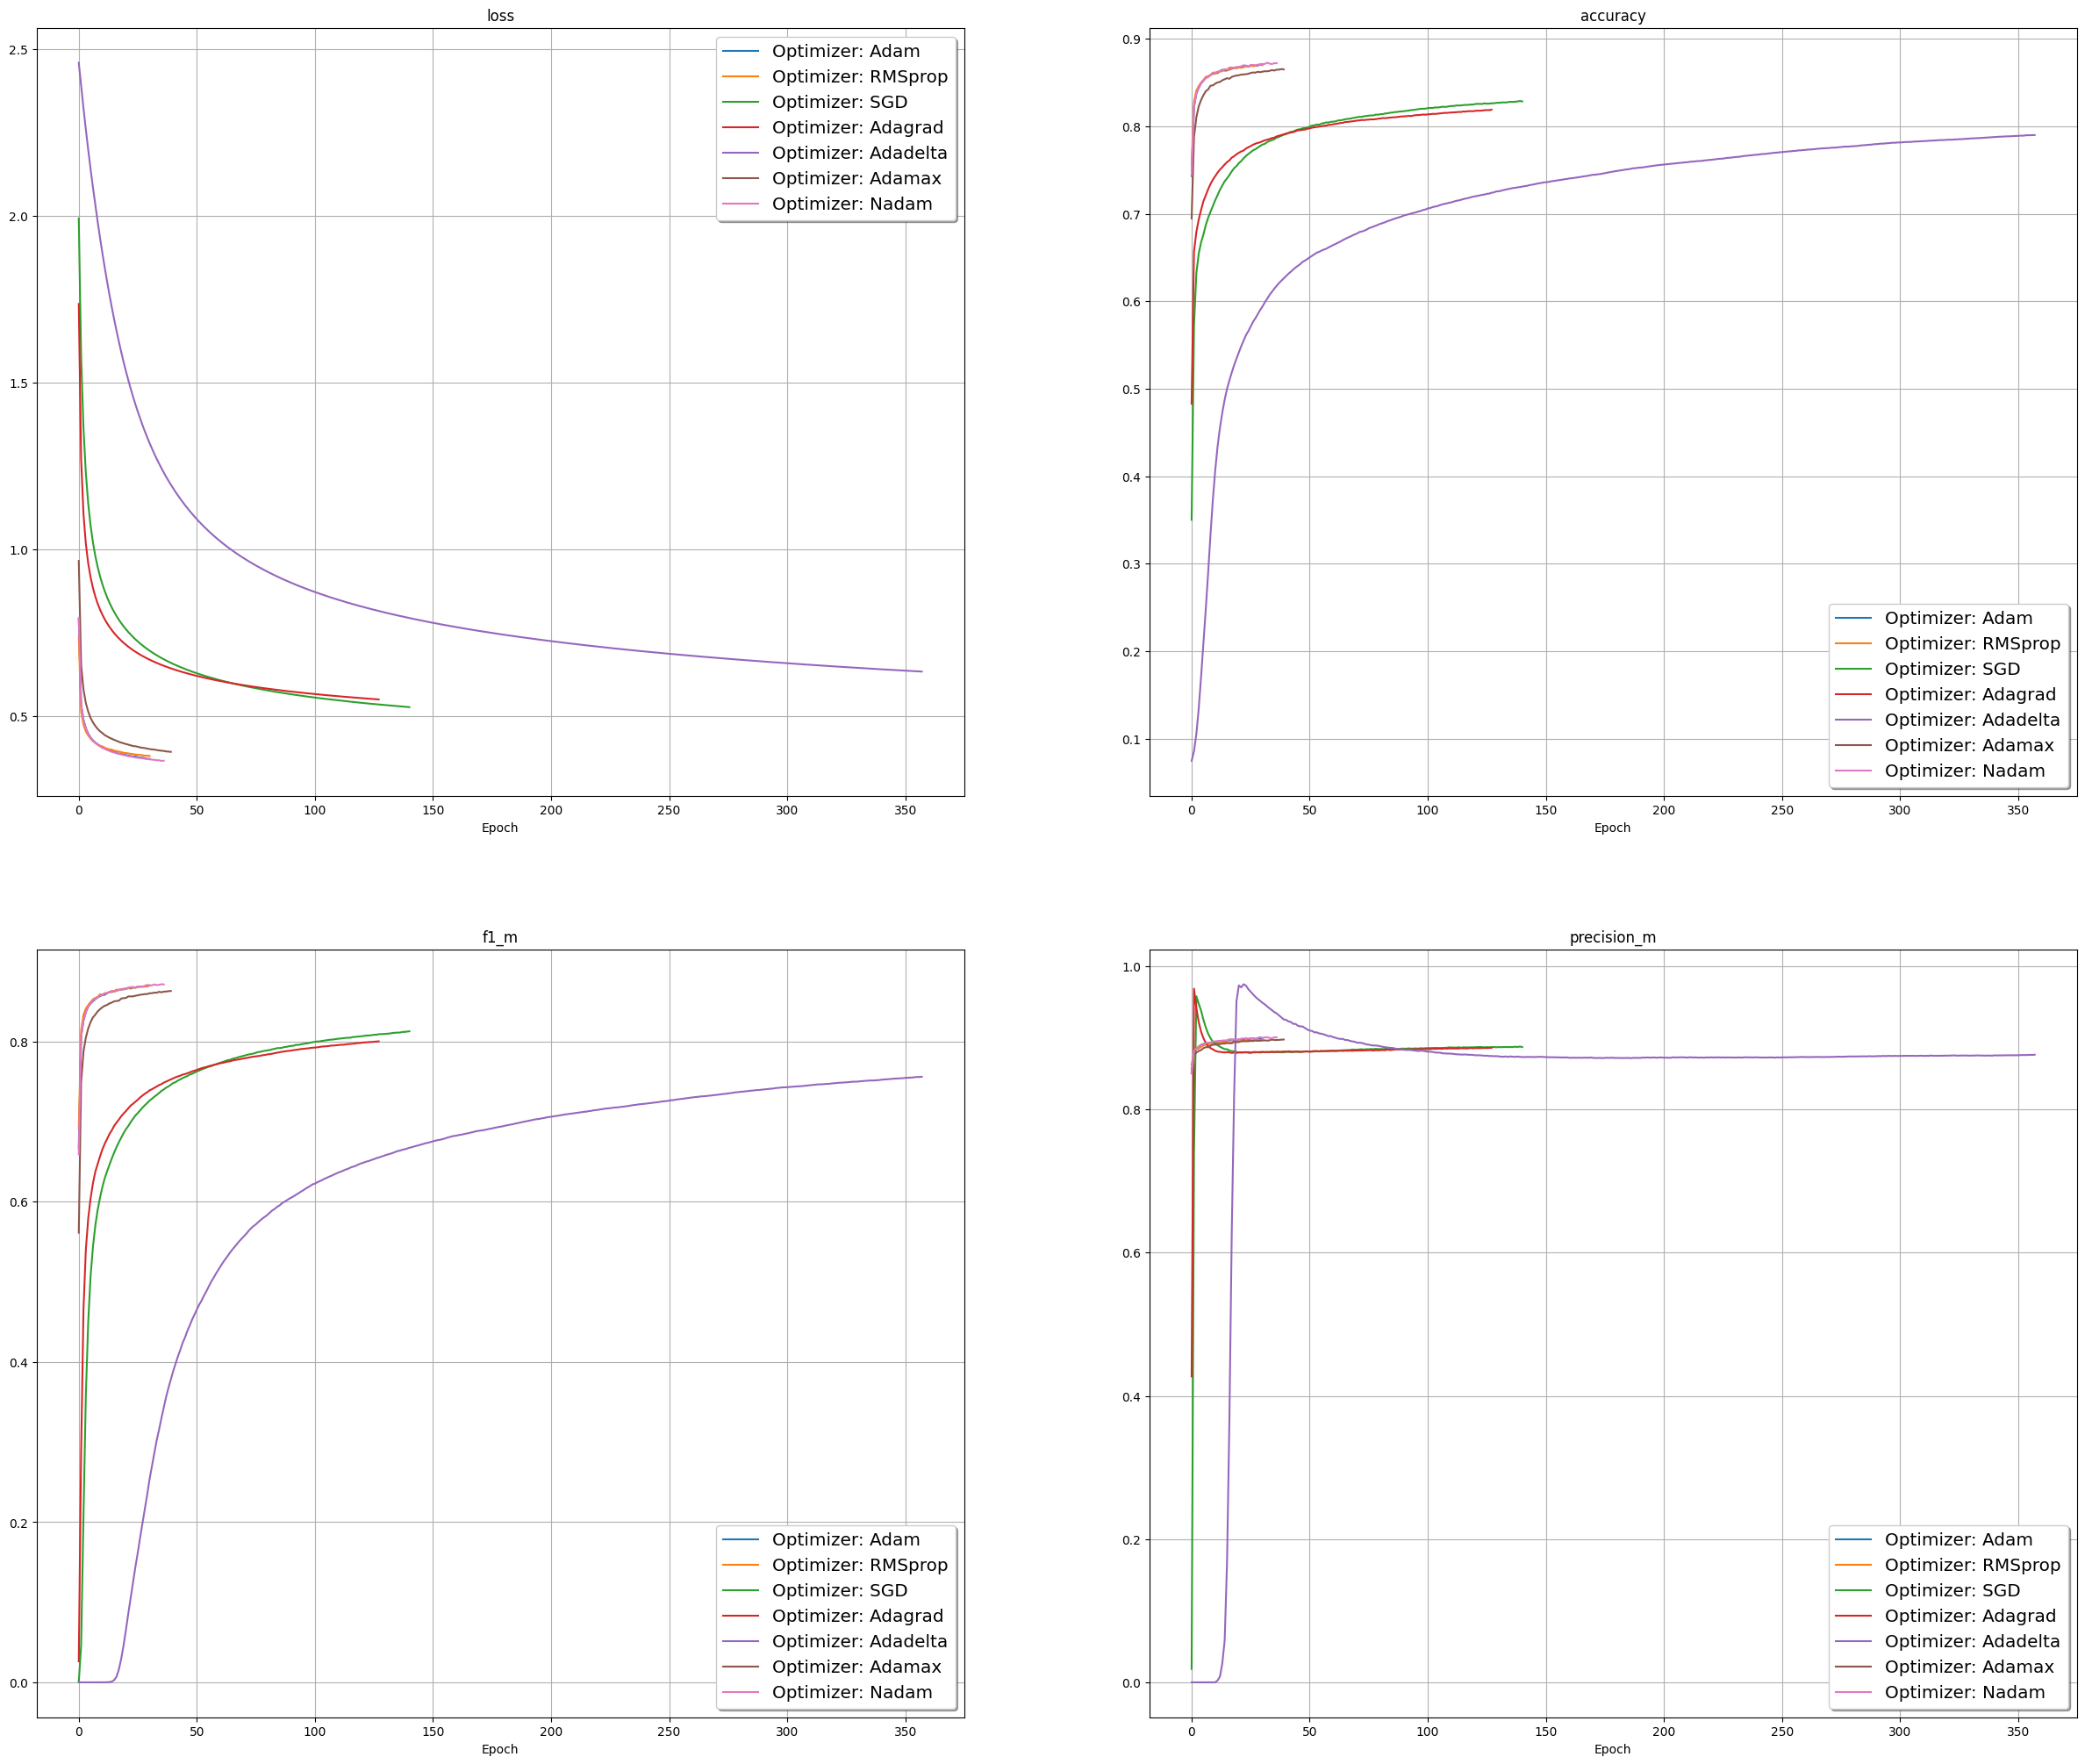

In [91]:
f, axis = plt.subplots(2, 2, figsize=(30, 25))
k = 0
for i in range(2):
    for j in range(2):
      for o in range(len(optimizers)):
        axis[i,j].plot(histories_o[o][metrics[k][0][0]], label=f'Optimizer: {optimizers[o].__name__}')
        axis[i,j].grid()
        axis[i,j].set_xlabel('Epoch')
        axis[i,j].legend(shadow=True, fontsize='x-large')
        axis[i,j].set_title(metrics[k][0][1])
      k += 1
plt.show()



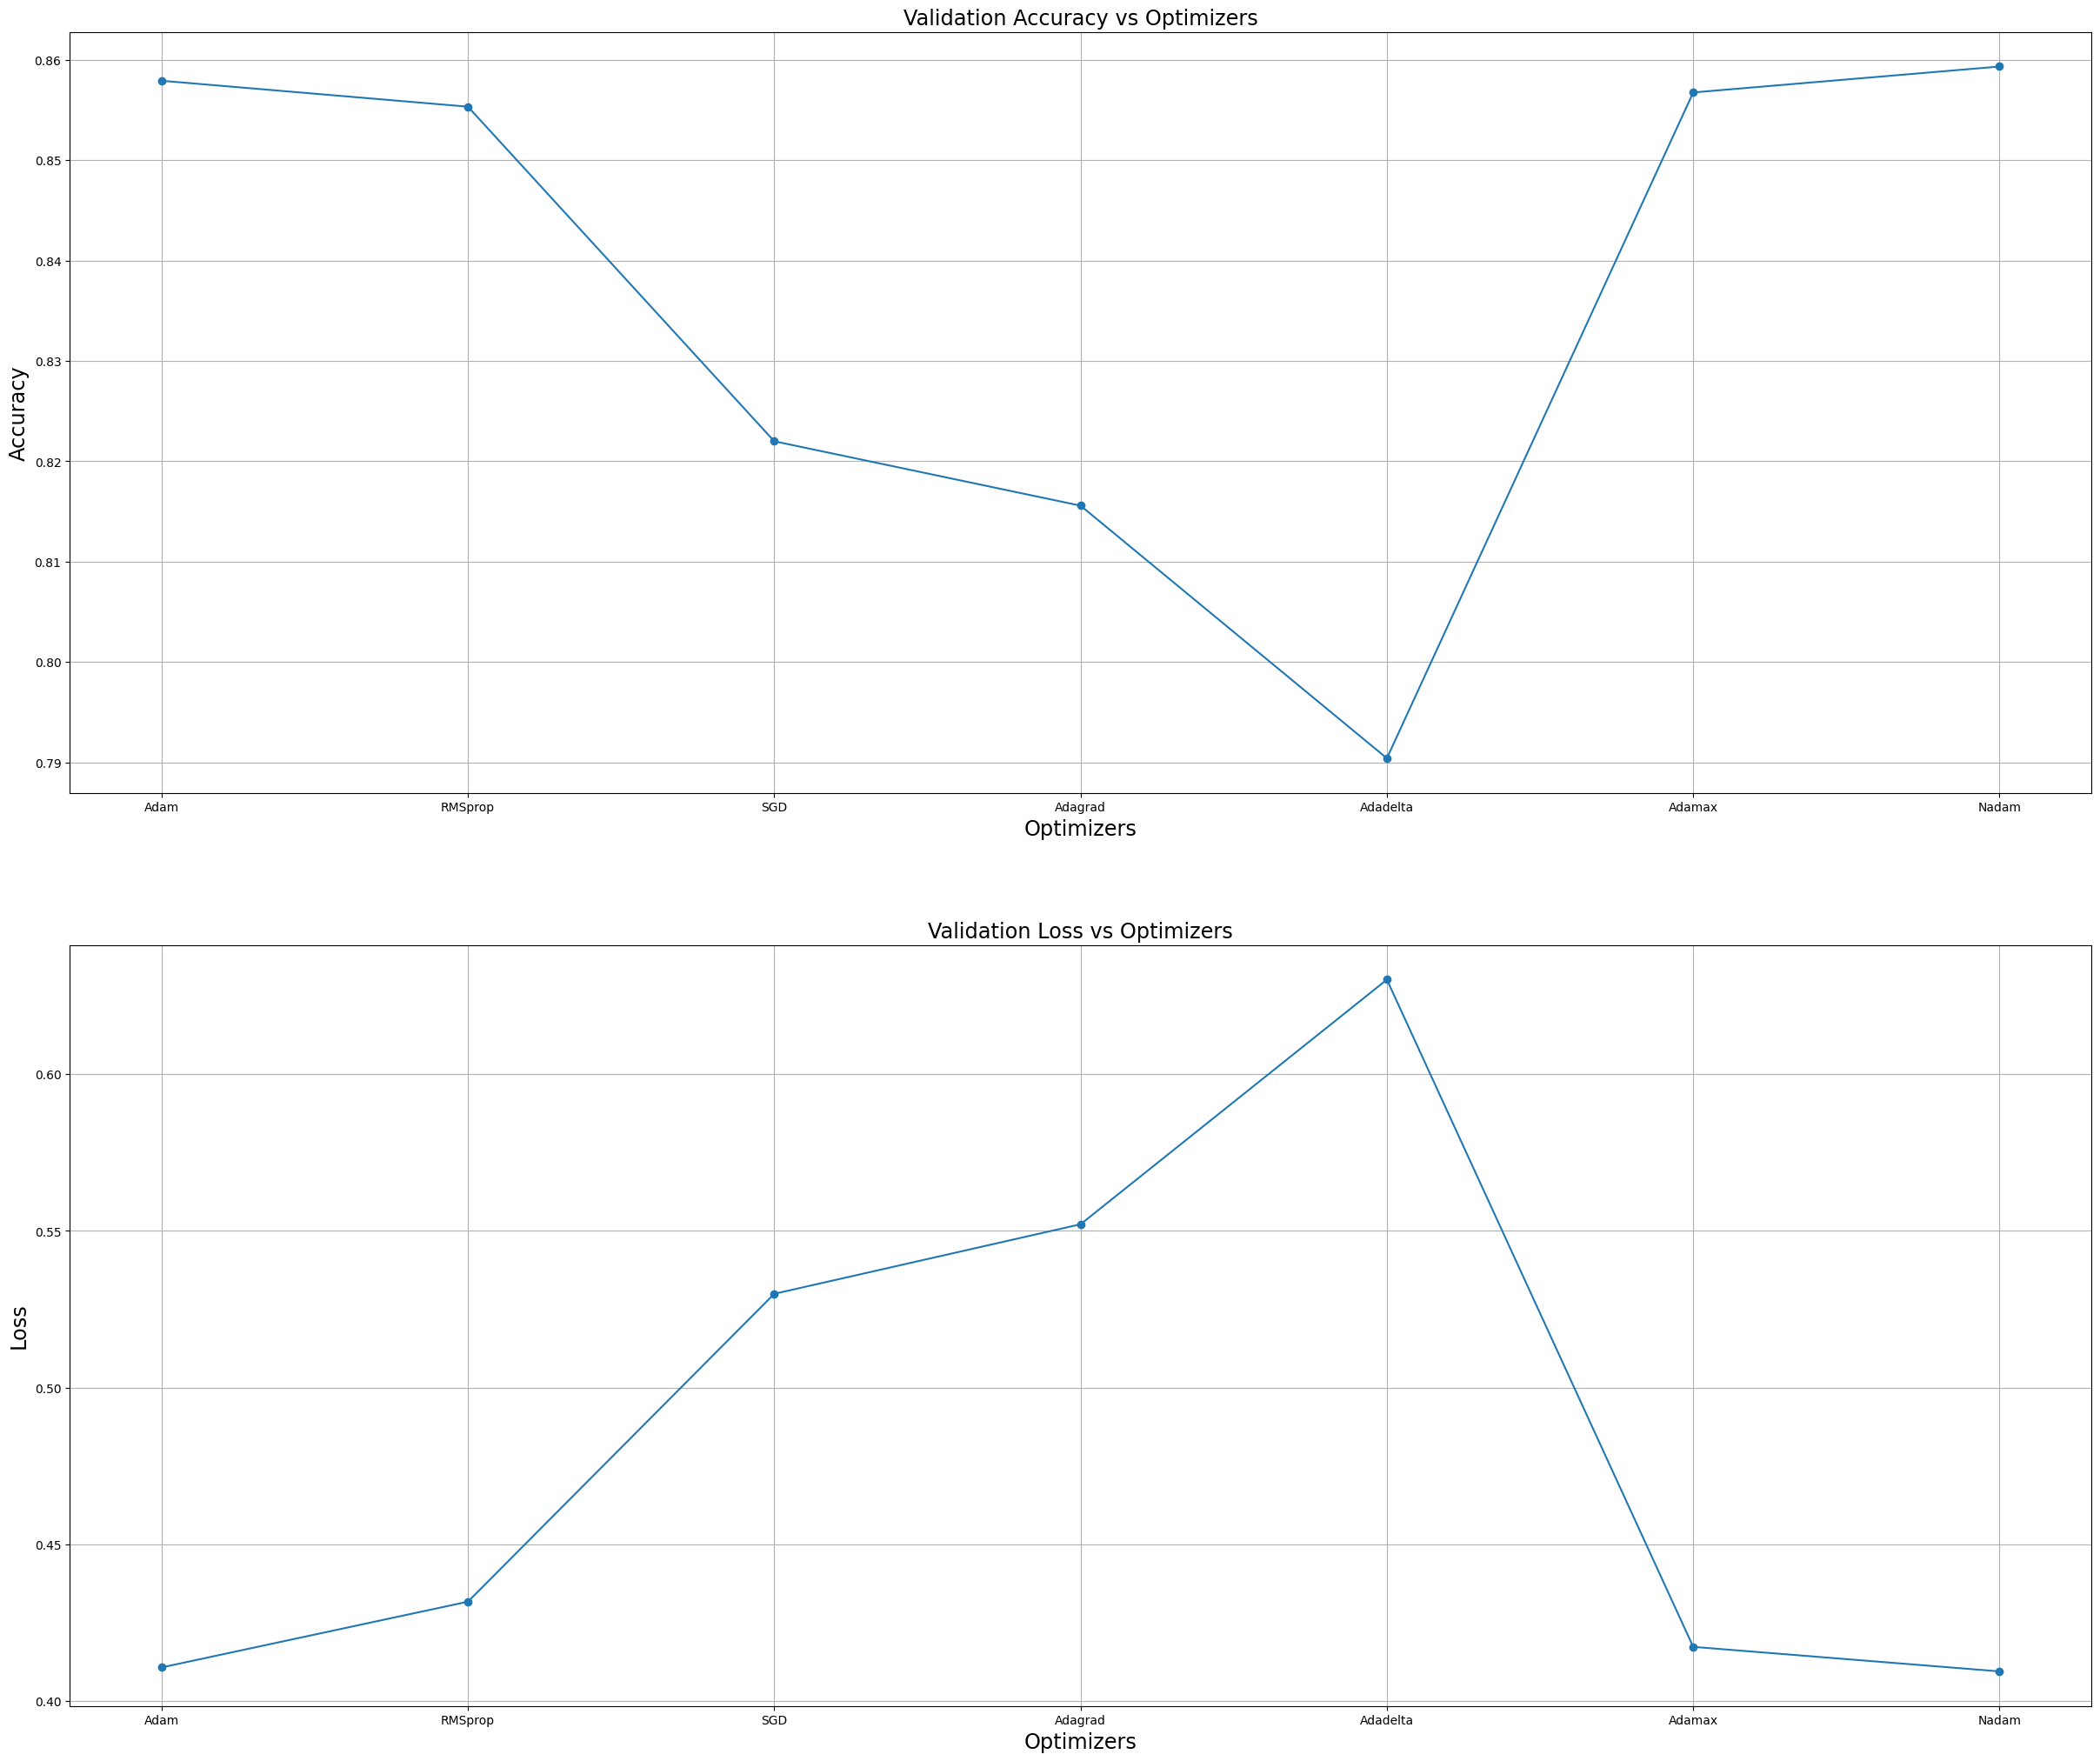

In [93]:
optimizer_names = [opt.__name__ for opt in optimizers]
final_accuracies = [acc[-1] for acc in accuracies_o]
final_losses = [loss[-1] for loss in losses_o]

# Plotting accuracies
f, axis = plt.subplots(2, 1, figsize=(30, 25))
axis[0].plot(optimizer_names, final_accuracies, marker = 'o')
axis[0].set_xlabel('Optimizers', fontsize='xx-large')
axis[0].set_ylabel('Accuracy', fontsize='xx-large')
axis[0].set_title('Validation Accuracy vs Optimizers', fontsize='xx-large')
axis[0].grid()

# Plotting losses
axis[1].plot(optimizer_names, final_losses, marker = 'o')
axis[1].set_xlabel('Optimizers', fontsize='xx-large')
axis[1].set_ylabel('Loss', fontsize='xx-large')
axis[1].set_title('Validation Loss vs Optimizers', fontsize='xx-large')
axis[1].grid()

plt.show()

We get the best results with Adam which makes sense due to its adaptative behaviour.

### Learning rate


In [94]:

learning_rate = [1, 0.1, 0.01, 0.001, 0.0001, 0.00001, 0.000001]

accuracies_lr = []
losses_lr = []
histories_lr = []
for lr in learning_rate:
    K.clear_session()
    model_lr = hp.classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 0,
                                    hidden_layers_units = [0],
                                    hidden_activation = 'sigmoid',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = 0.0,
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=False,
                                    lr = lr,
                                    decay = 0,
                                    out_softmax = True,
                                    optimizer = Adam)
    model_trained_lr = model_lr.fit(    x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=128,
                                  verbose=0,
                                  validation_data = (x_val, y_val_categorical),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )
    accuracies_lr.append(model_trained_lr.history['val_accuracy'])
    losses_lr.append(model_trained_lr.history['val_loss'])
    histories_lr.append(model_trained_lr.history)

Epoch 31: early stopping
Epoch 37: early stopping
Epoch 34: early stopping
Epoch 31: early stopping
Epoch 60: early stopping
Epoch 139: early stopping
Epoch 406: early stopping


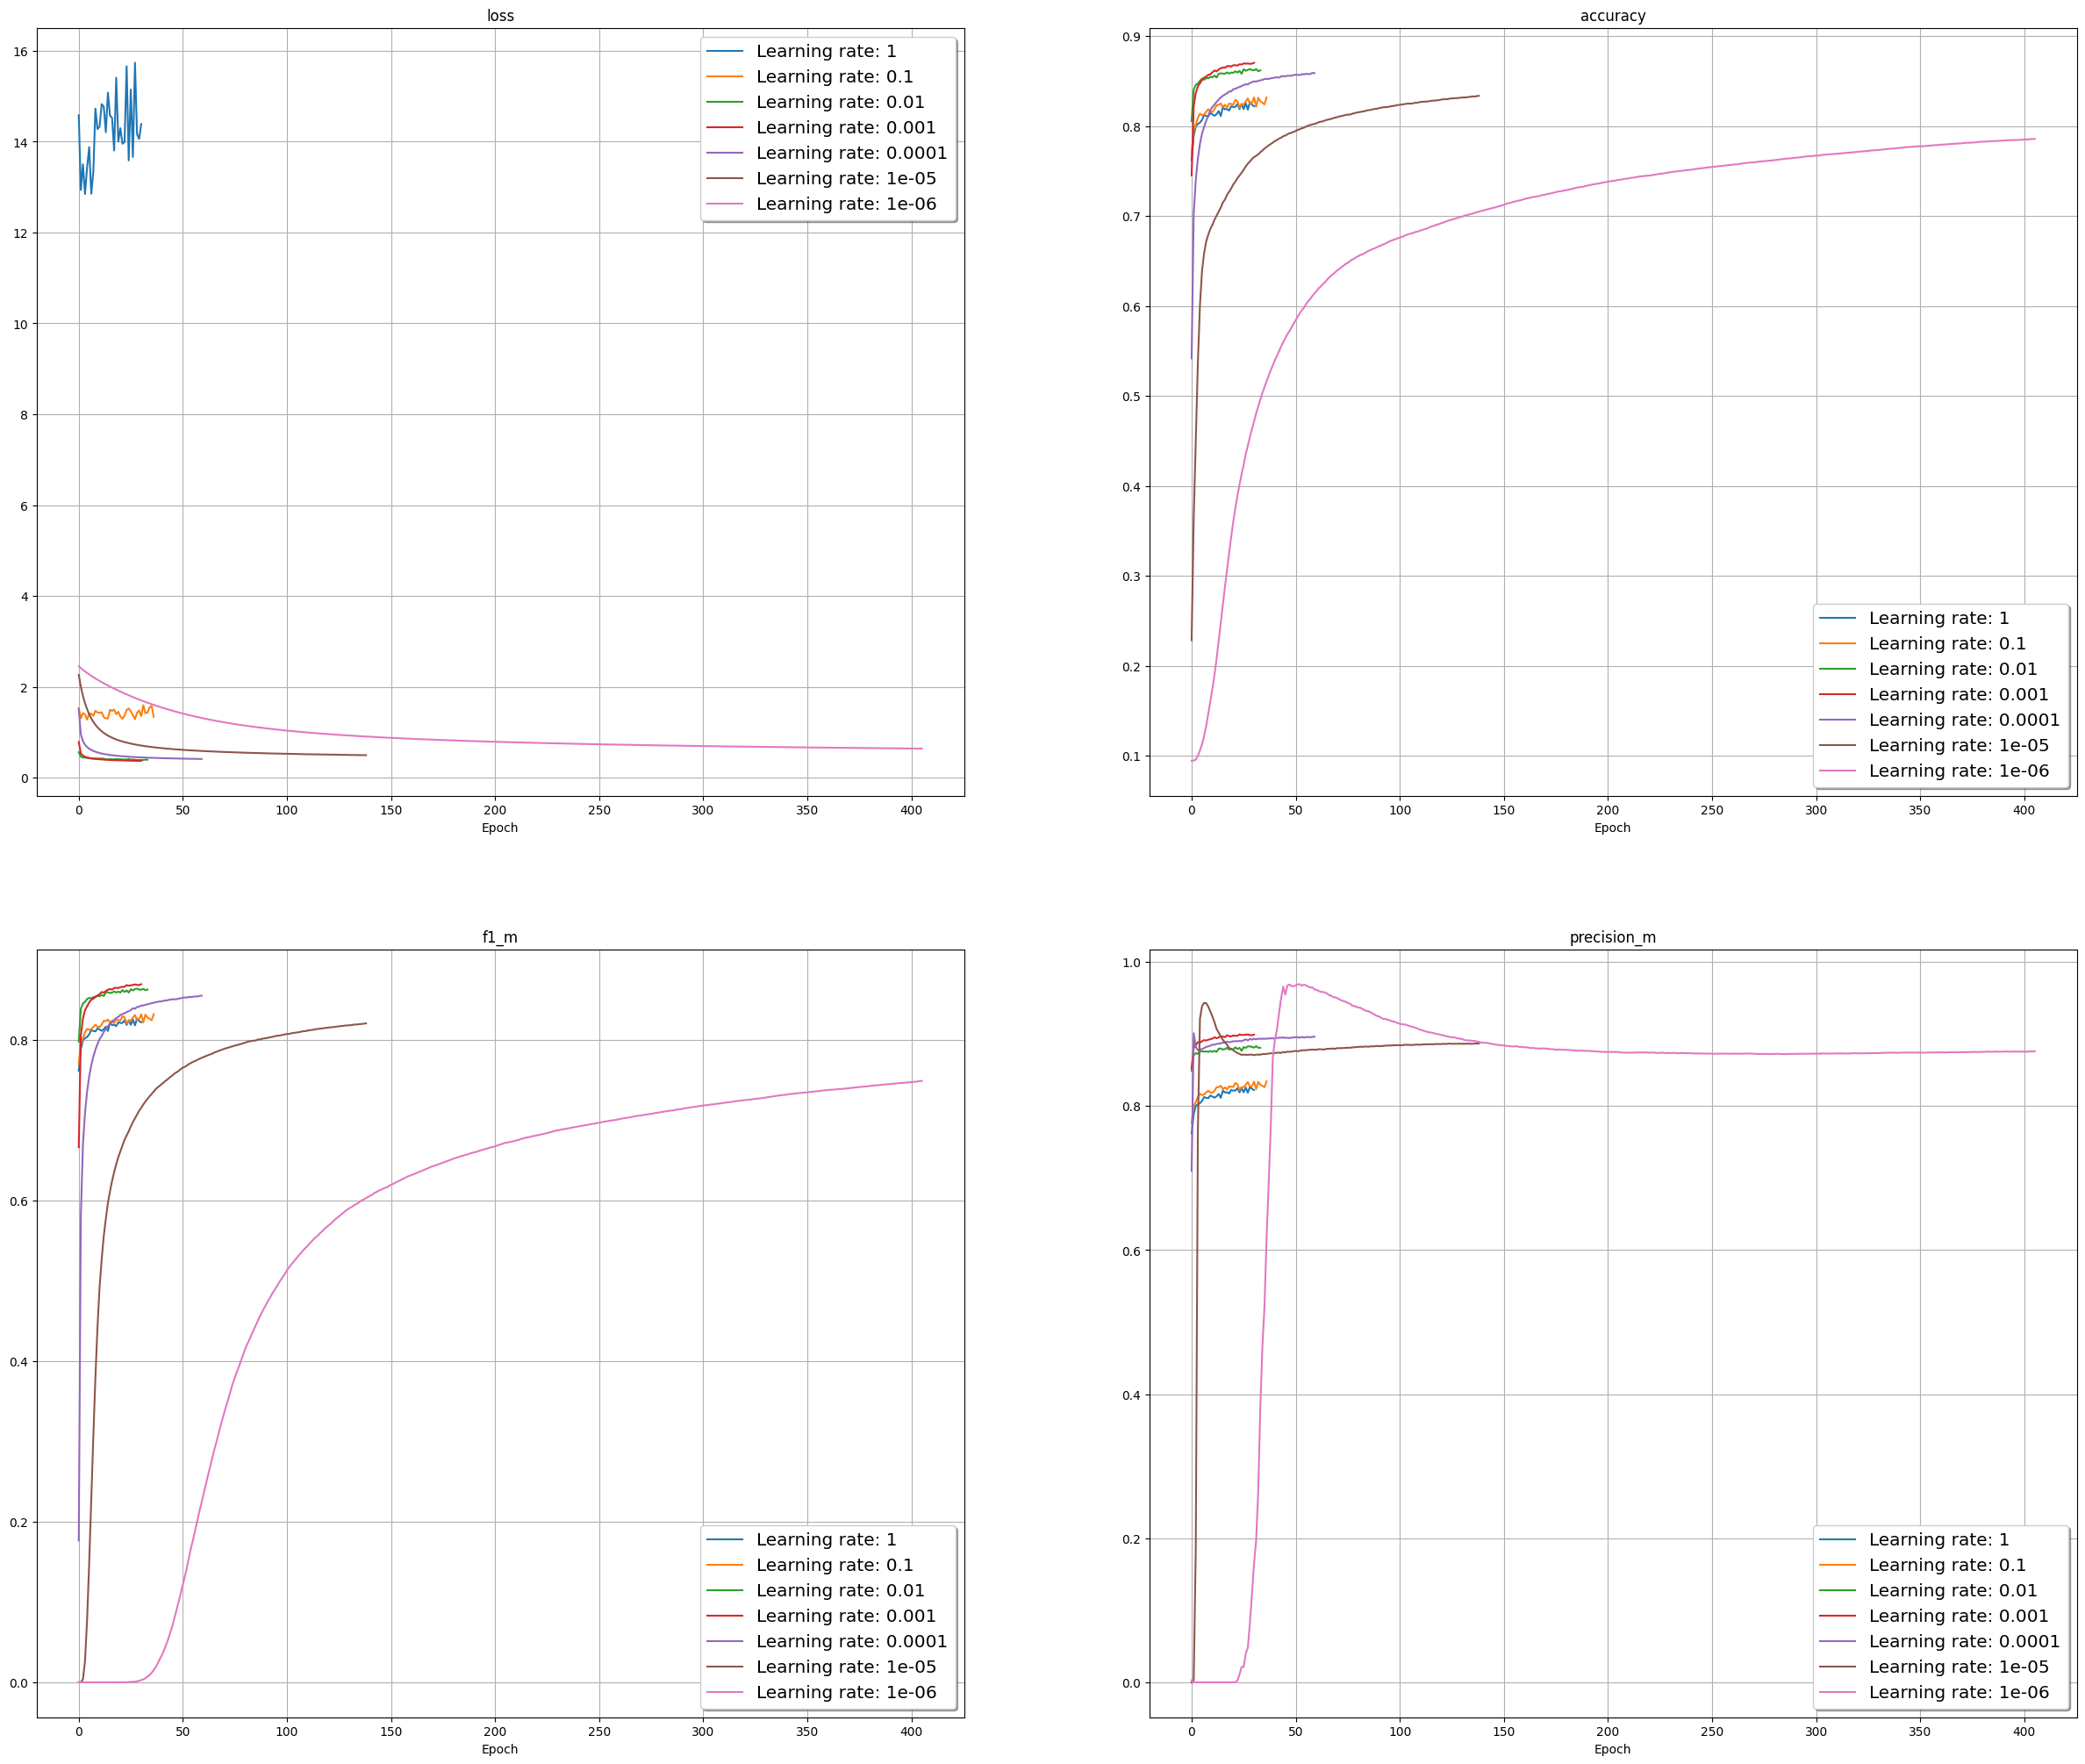

In [95]:
f, axis = plt.subplots(2, 2, figsize=(30, 25))
k = 0
for i in range(2):
    for j in range(2):
      for lr in range(len(learning_rate)):
        axis[i,j].plot(histories_lr[lr][metrics[k][0][0]], label=f'Learning rate: {learning_rate[lr]}')
        axis[i,j].grid()
        axis[i,j].set_xlabel('Epoch')
        axis[i,j].legend(shadow=True, fontsize='x-large')
        axis[i,j].set_title(metrics[k][0][1])
      k += 1
plt.show()


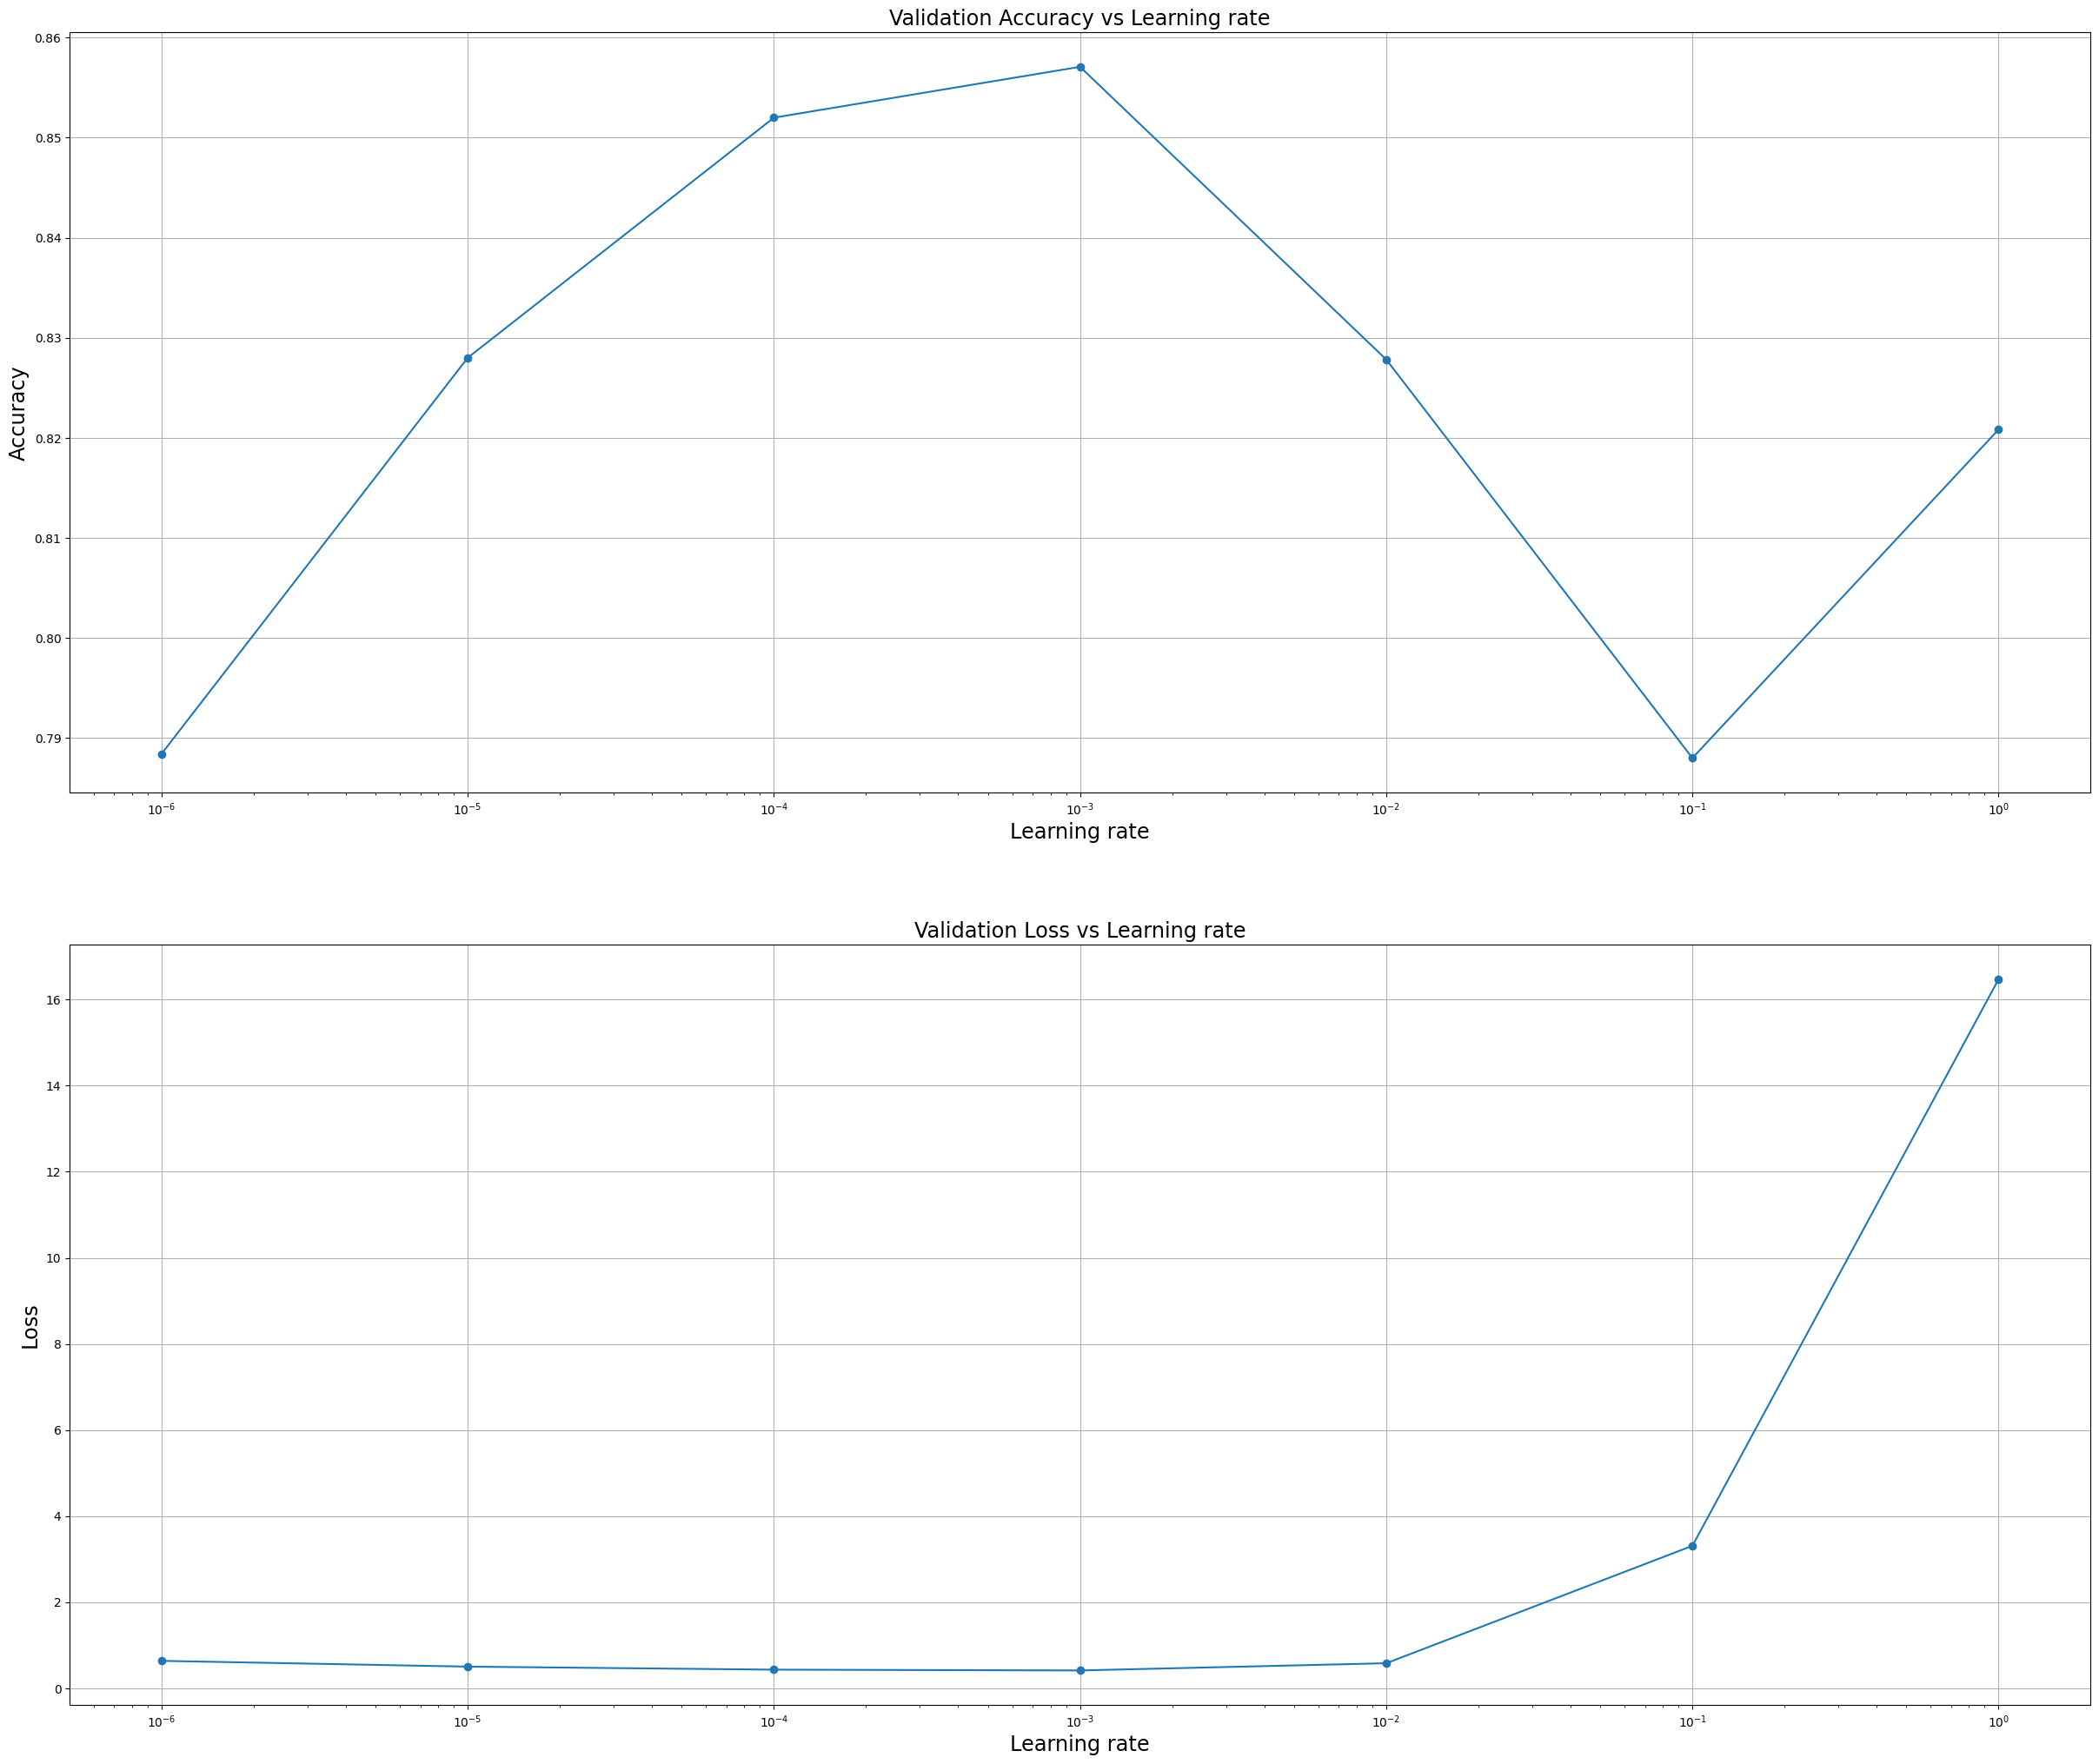

In [96]:
final_accuracies = [acc[-1] for acc in accuracies_lr]
final_losses = [loss[-1] for loss in losses_lr]

# Plotting accuracies
f, axis = plt.subplots(2, 1, figsize=(30, 25))
axis[0].plot(learning_rate, final_accuracies, marker = 'o')
axis[0].set_xlabel('Learning rate', fontsize='xx-large')
axis[0].set_ylabel('Accuracy', fontsize='xx-large')
axis[0].set_title('Validation Accuracy vs Learning rate', fontsize='xx-large')
axis[0].set_xscale('log')
axis[0].grid()

# Plotting losses
axis[1].plot(learning_rate, final_losses, marker = 'o')
axis[1].set_xlabel('Learning rate', fontsize='xx-large')
axis[1].set_ylabel('Loss', fontsize='xx-large')
axis[1].set_title('Validation Loss vs Learning rate', fontsize='xx-large')
axis[1].set_xscale('log')
axis[1].grid()

plt.show()

We can see how convergence gets tougher when the learning path is smaller, as it takes so much time (406 epochs!!), as well as when the learning path is too big as it may oscilate around the local minimum. lr = 0.0001 is a good one.

### Batch size

In [63]:
batch_size = [2048, 1024, 512, 256, 128, 64, 32]

accuracies_bs = []
losses_bs = []
histories_bs = []
for bs in batch_size:
    K.clear_session()
    model_opt = hp.classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 0,
                                    hidden_layers_units = [0],
                                    hidden_activation = 'sigmoid',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = 0.0,
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=False,
                                    lr = 0.001,
                                    decay = 0,
                                    out_softmax = True,
                                    optimizer = Adam)
    model_trained_opt = model_opt.fit(    x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=bs,
                                  verbose=0,
                                  validation_data = (x_val, y_val_categorical),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )
    accuracies_bs.append(model_trained_opt.history['val_accuracy'])
    losses_bs.append(model_trained_opt.history['val_loss'])
    histories_bs.append(model_trained_opt.history)


Epoch 85: early stopping
Epoch 53: early stopping
Epoch 42: early stopping
Epoch 41: early stopping
Epoch 31: early stopping
Epoch 31: early stopping
Epoch 31: early stopping


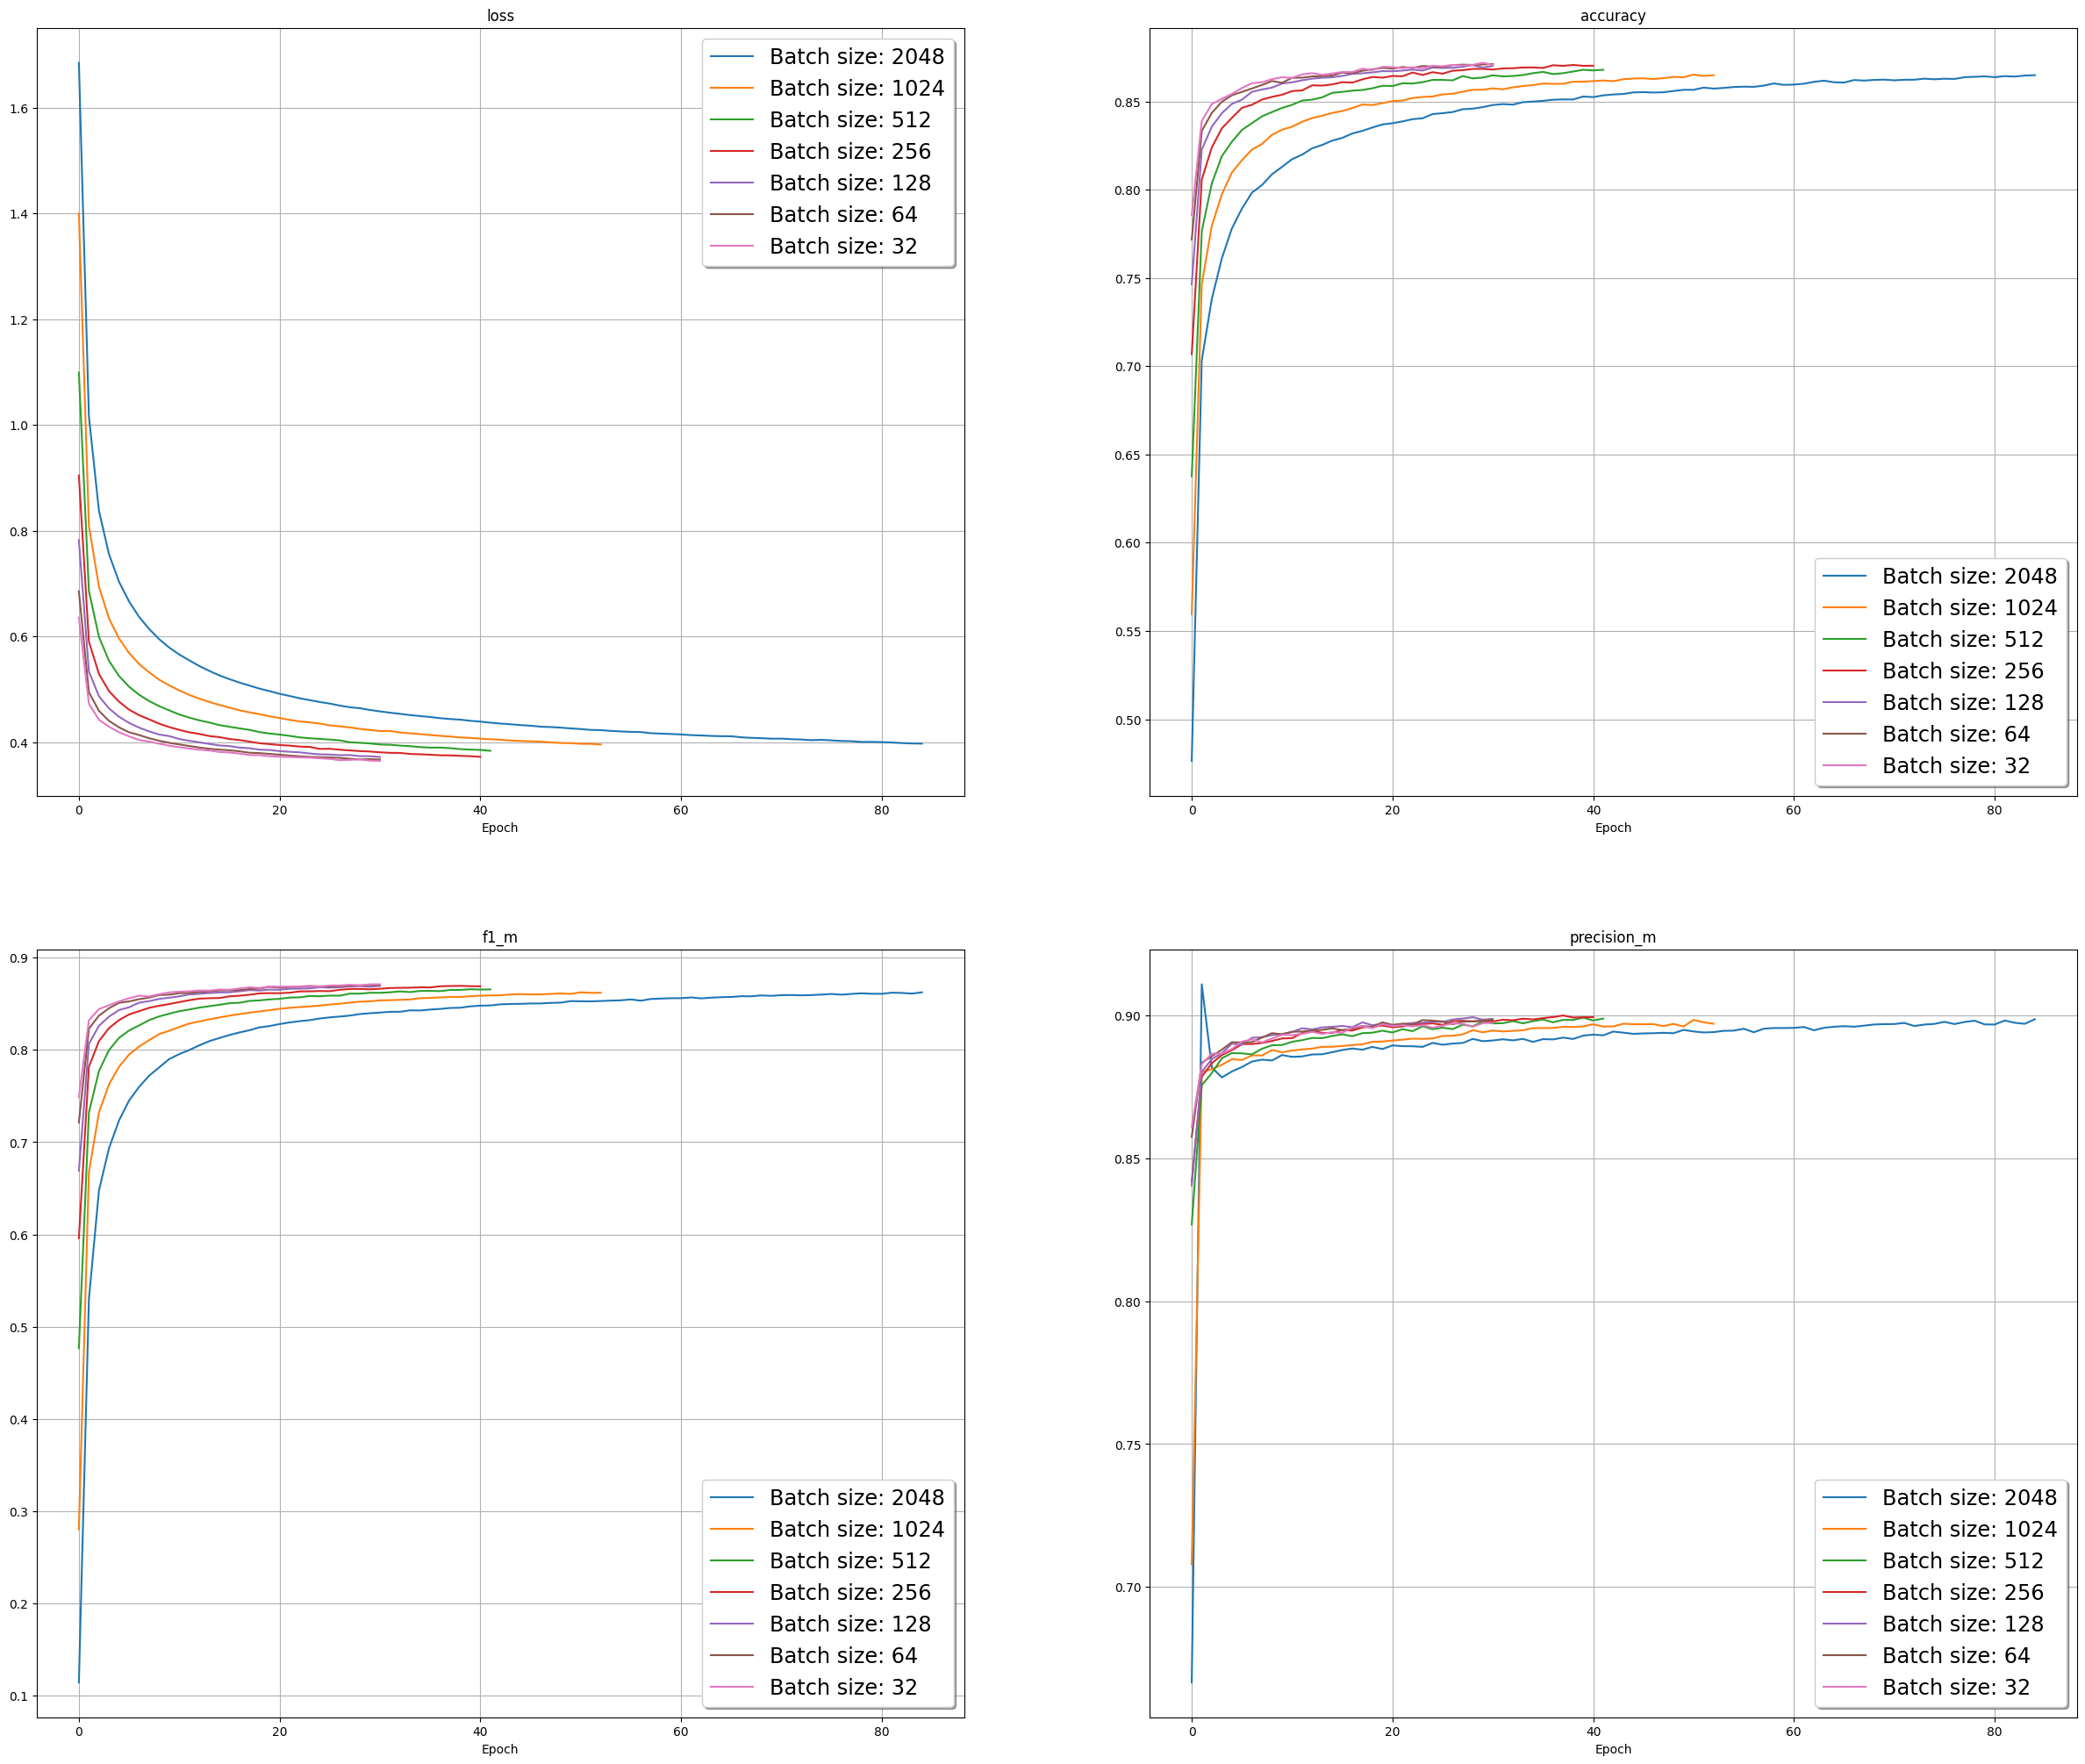

In [64]:
f, axis = plt.subplots(2, 2, figsize=(30, 25))
k = 0
for i in range(2):
    for j in range(2):
      for bs in range(len(batch_size)):
        axis[i,j].plot(histories_bs[bs][metrics[k][0][0]], label=f'Batch size: {batch_size[bs]}')
        axis[i,j].grid()
        axis[i,j].set_xlabel('Epoch')
        axis[i,j].legend(shadow=True, fontsize='xx-large')
        axis[i,j].set_title(metrics[k][0][1])
      k += 1
plt.show()



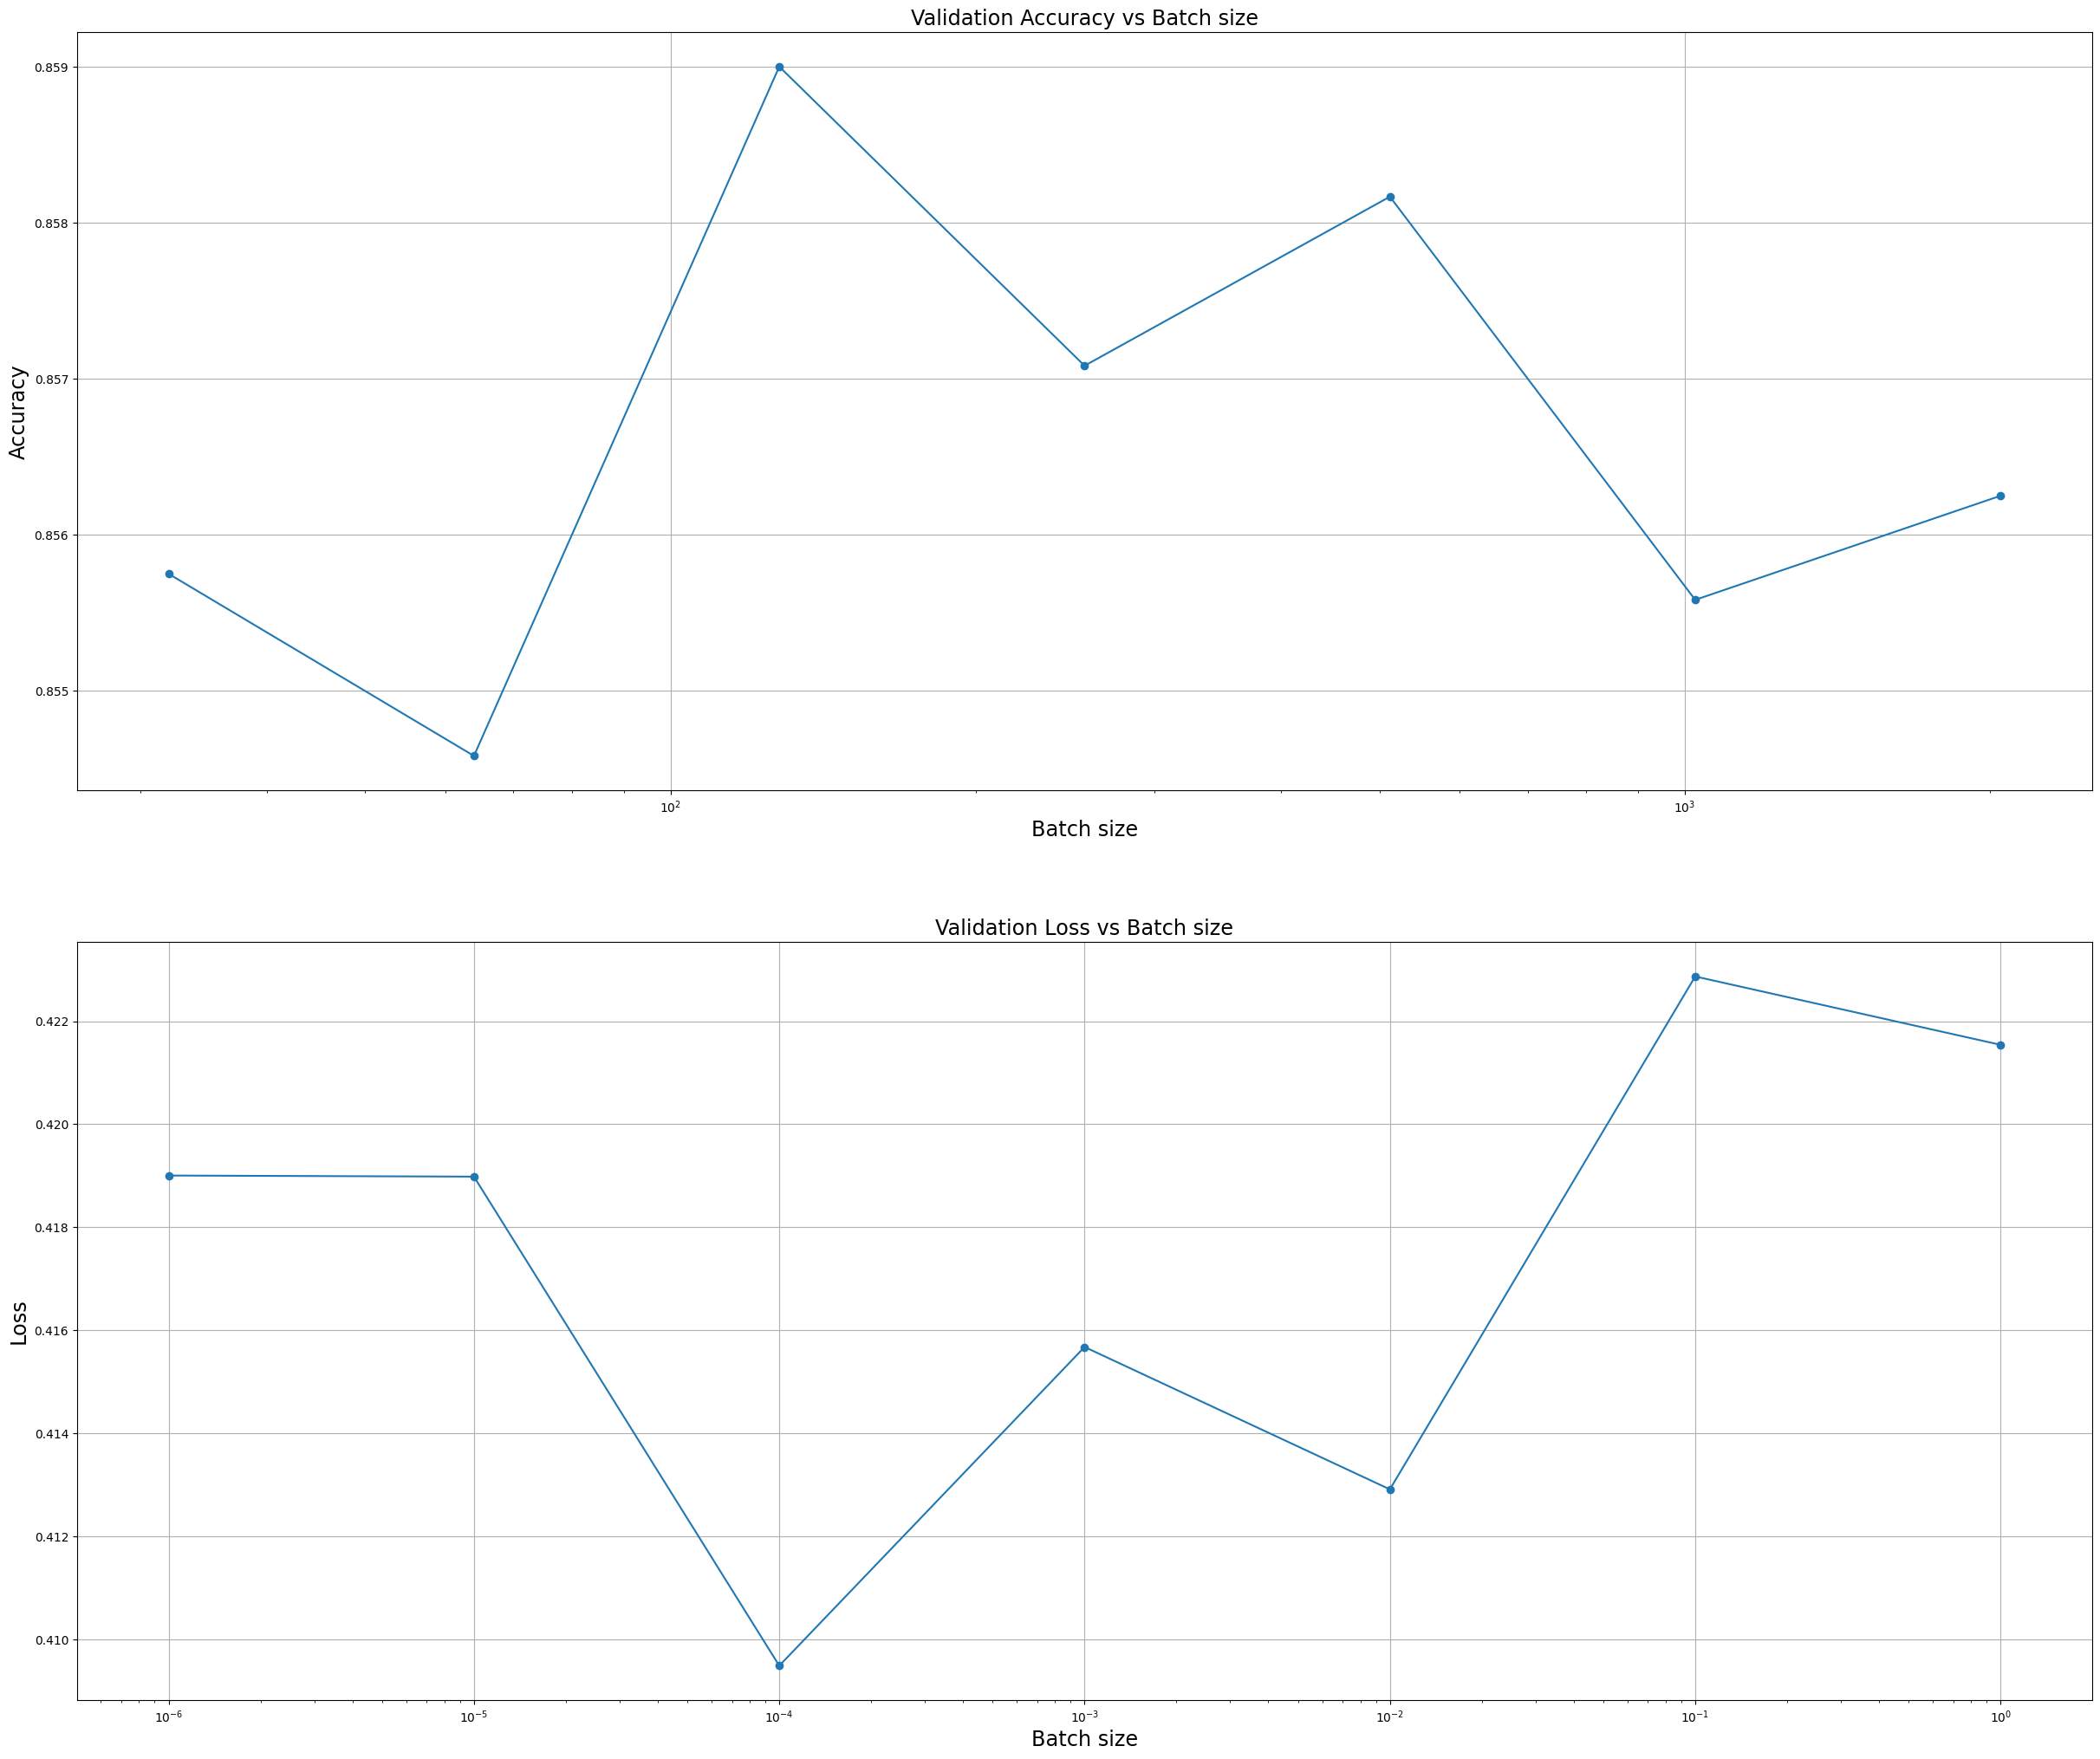

In [102]:
final_accuracies = [acc[-1] for acc in accuracies_bs]
final_losses = [loss[-1] for loss in losses_bs]

# Plotting accuracies
f, axis = plt.subplots(2, 1, figsize=(30, 25))
axis[0].plot(batch_size, final_accuracies, marker = 'o')
axis[0].set_xlabel('Batch size', fontsize='xx-large')
axis[0].set_ylabel('Accuracy', fontsize='xx-large')
axis[0].set_title('Validation Accuracy vs Batch size', fontsize='xx-large')
axis[0].set_xscale('log')
axis[0].grid()

# Plotting losses
axis[1].plot(learning_rate, final_losses, marker = 'o')
axis[1].set_xlabel('Batch size', fontsize='xx-large')
axis[1].set_ylabel('Loss', fontsize='xx-large')
axis[1].set_title('Validation Loss vs Batch size', fontsize='xx-large')
axis[1].set_xscale('log')
axis[1].grid()

plt.show()

We get the best results with batch size = 128. Bigger batch sizes means less actualizations and less noise, whereas smaller batch sizes means more variance as well as more actualization while training.

### Dropout rate

In [97]:
dropout_rate = [0, 0.0625, 0.125, 0.25, 0.5]

accuracies_dr = []
losses_dr = []
histories_dr = []
for dr in dropout_rate:
    K.clear_session()
    model_dr = hp.classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 0,
                                    hidden_layers_units = [0],
                                    hidden_activation = 'sigmoid',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = dr,
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=False,
                                    lr = 0.0001,
                                    decay = 0,
                                    out_softmax = True,
                                    optimizer = Adam)
    model_trained_dr = model_dr.fit(    x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=128,
                                  verbose=0,
                                  validation_data = (x_val, y_val_categorical),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )
    accuracies_dr.append(model_trained_dr.history['val_accuracy'])
    losses_dr.append(model_trained_dr.history['val_loss'])
    histories_dr.append(model_trained_dr.history)


Epoch 82: early stopping
Epoch 90: early stopping
Epoch 86: early stopping
Epoch 63: early stopping
Epoch 79: early stopping


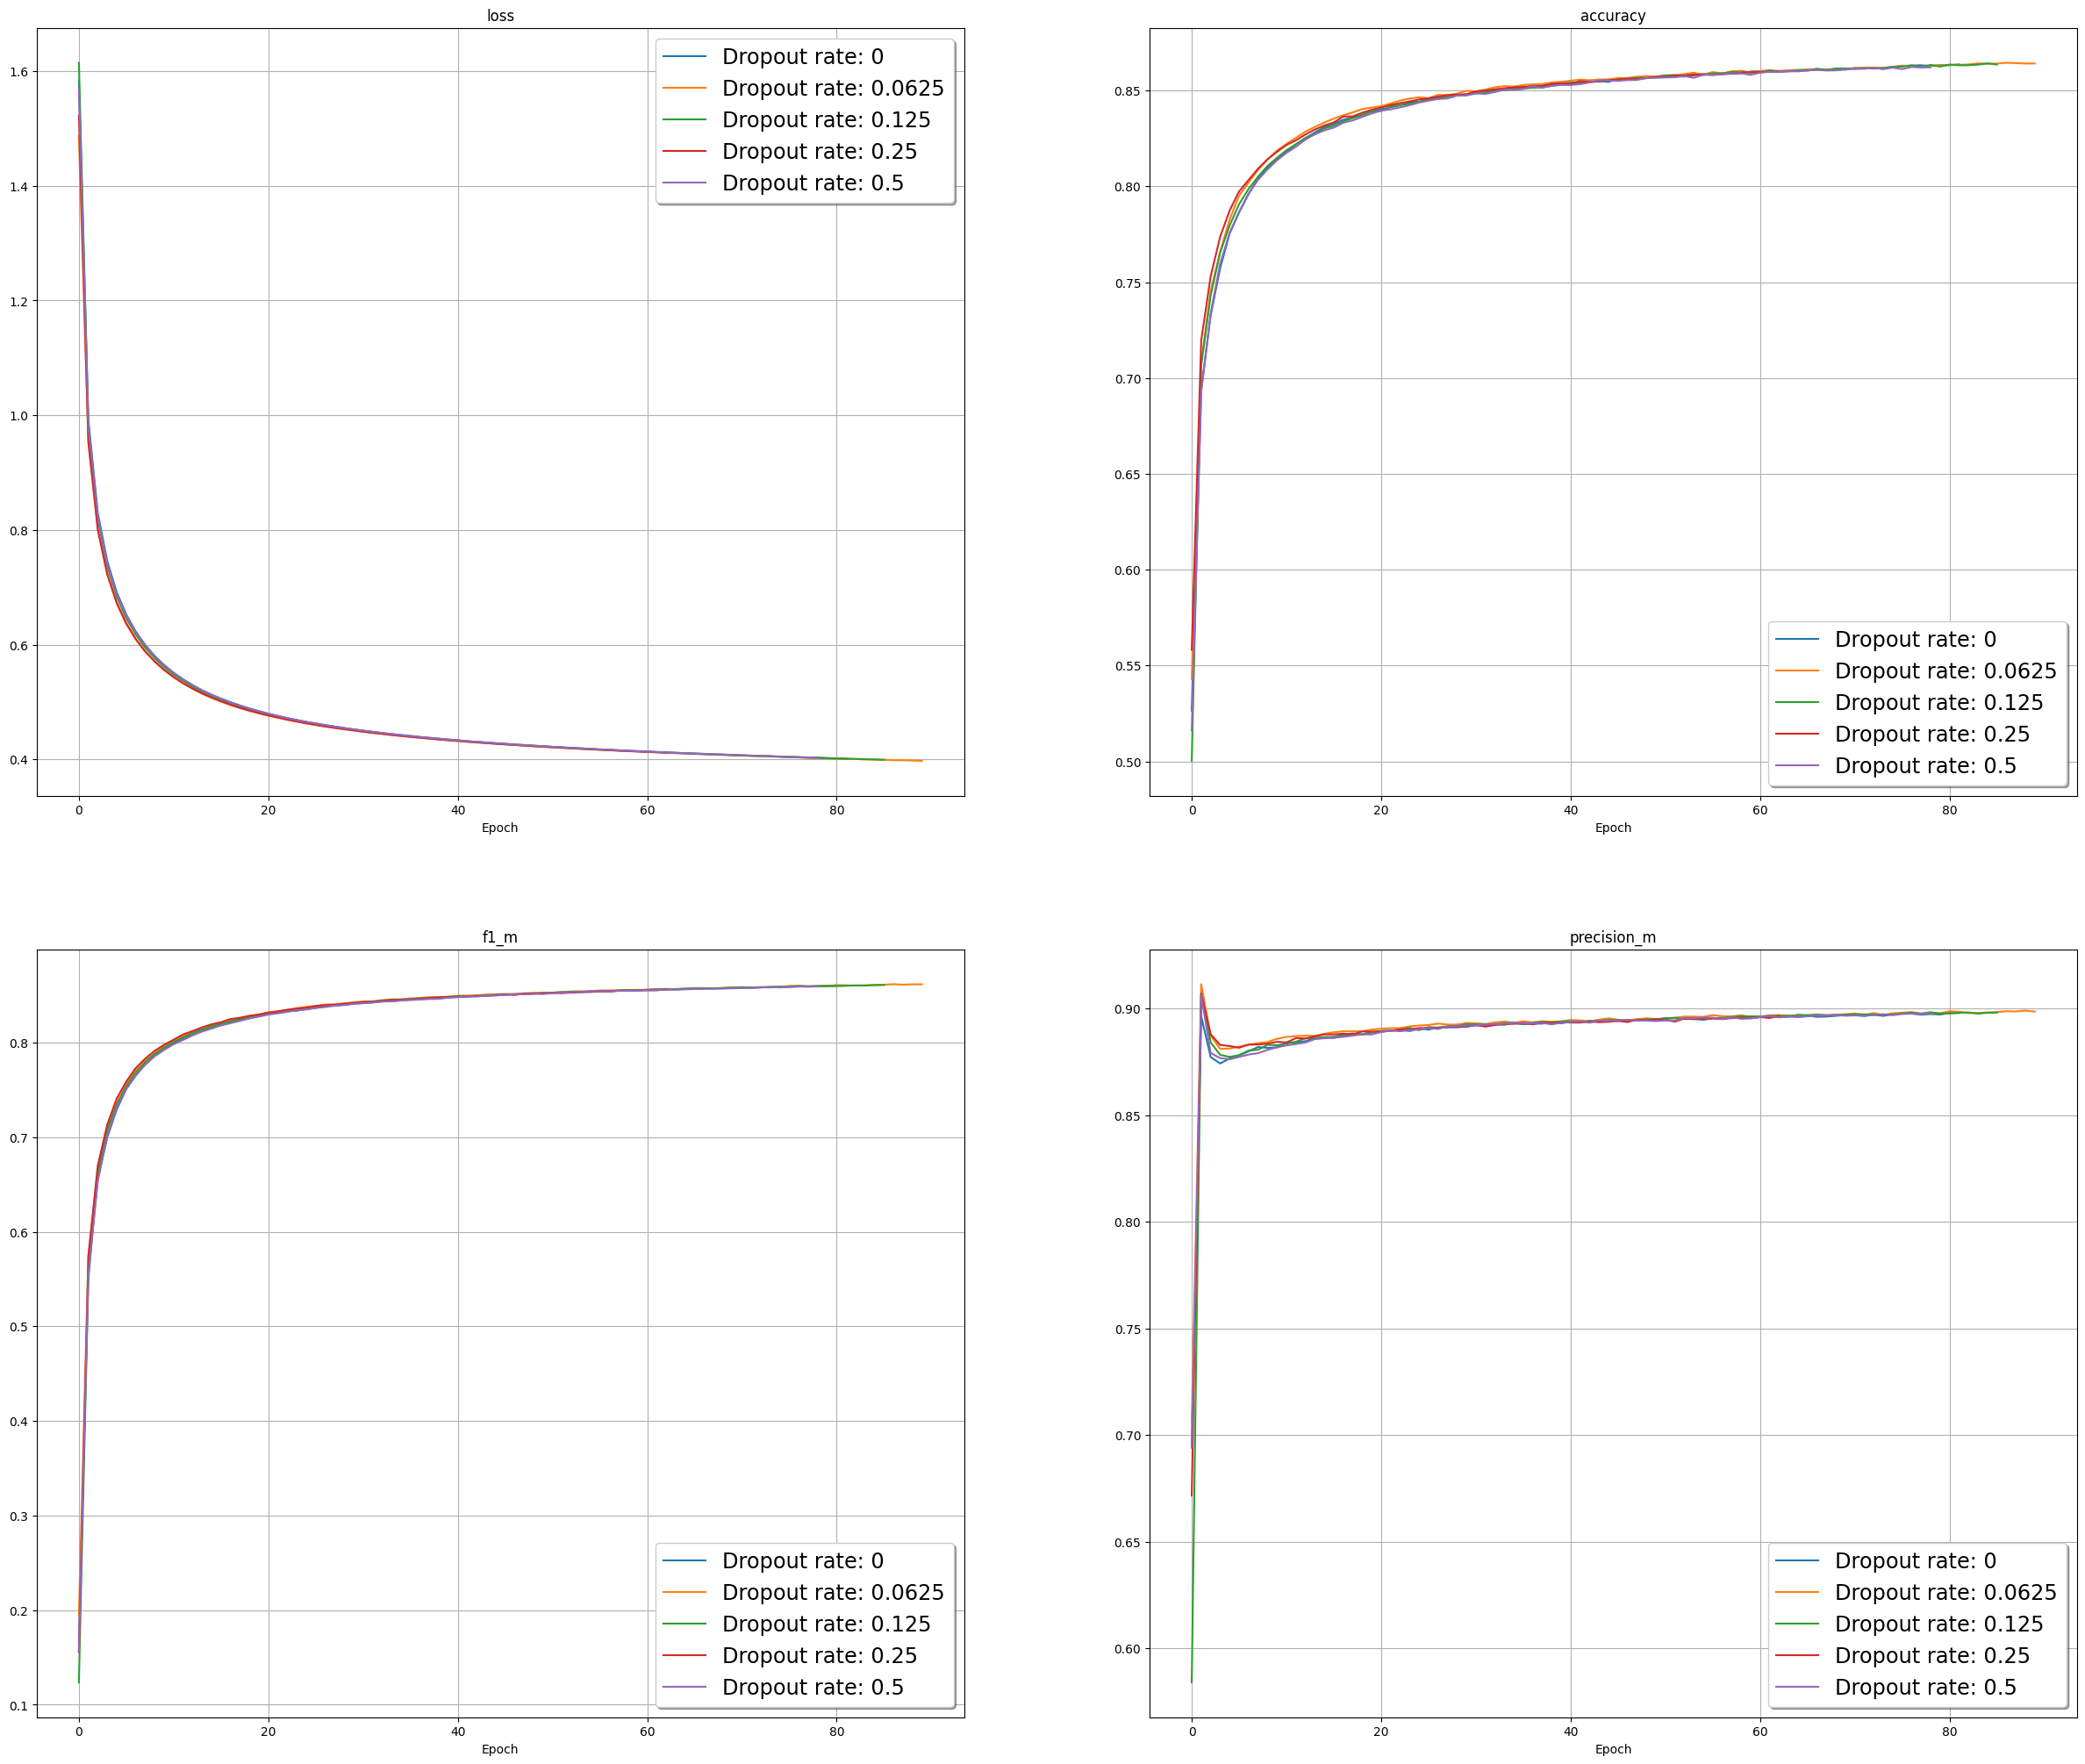

In [98]:
f, axis = plt.subplots(2, 2, figsize=(30, 25))
k = 0
for i in range(2):
    for j in range(2):
      for dr in range(len(dropout_rate)):
        axis[i,j].plot(histories_dr[dr][metrics[k][0][0]], label=f'Dropout rate: {dropout_rate[dr]}')
        axis[i,j].grid()
        axis[i,j].set_xlabel('Epoch')
        axis[i,j].legend(shadow=True, fontsize='xx-large')
        axis[i,j].set_title(metrics[k][0][1])
      k += 1
plt.show()

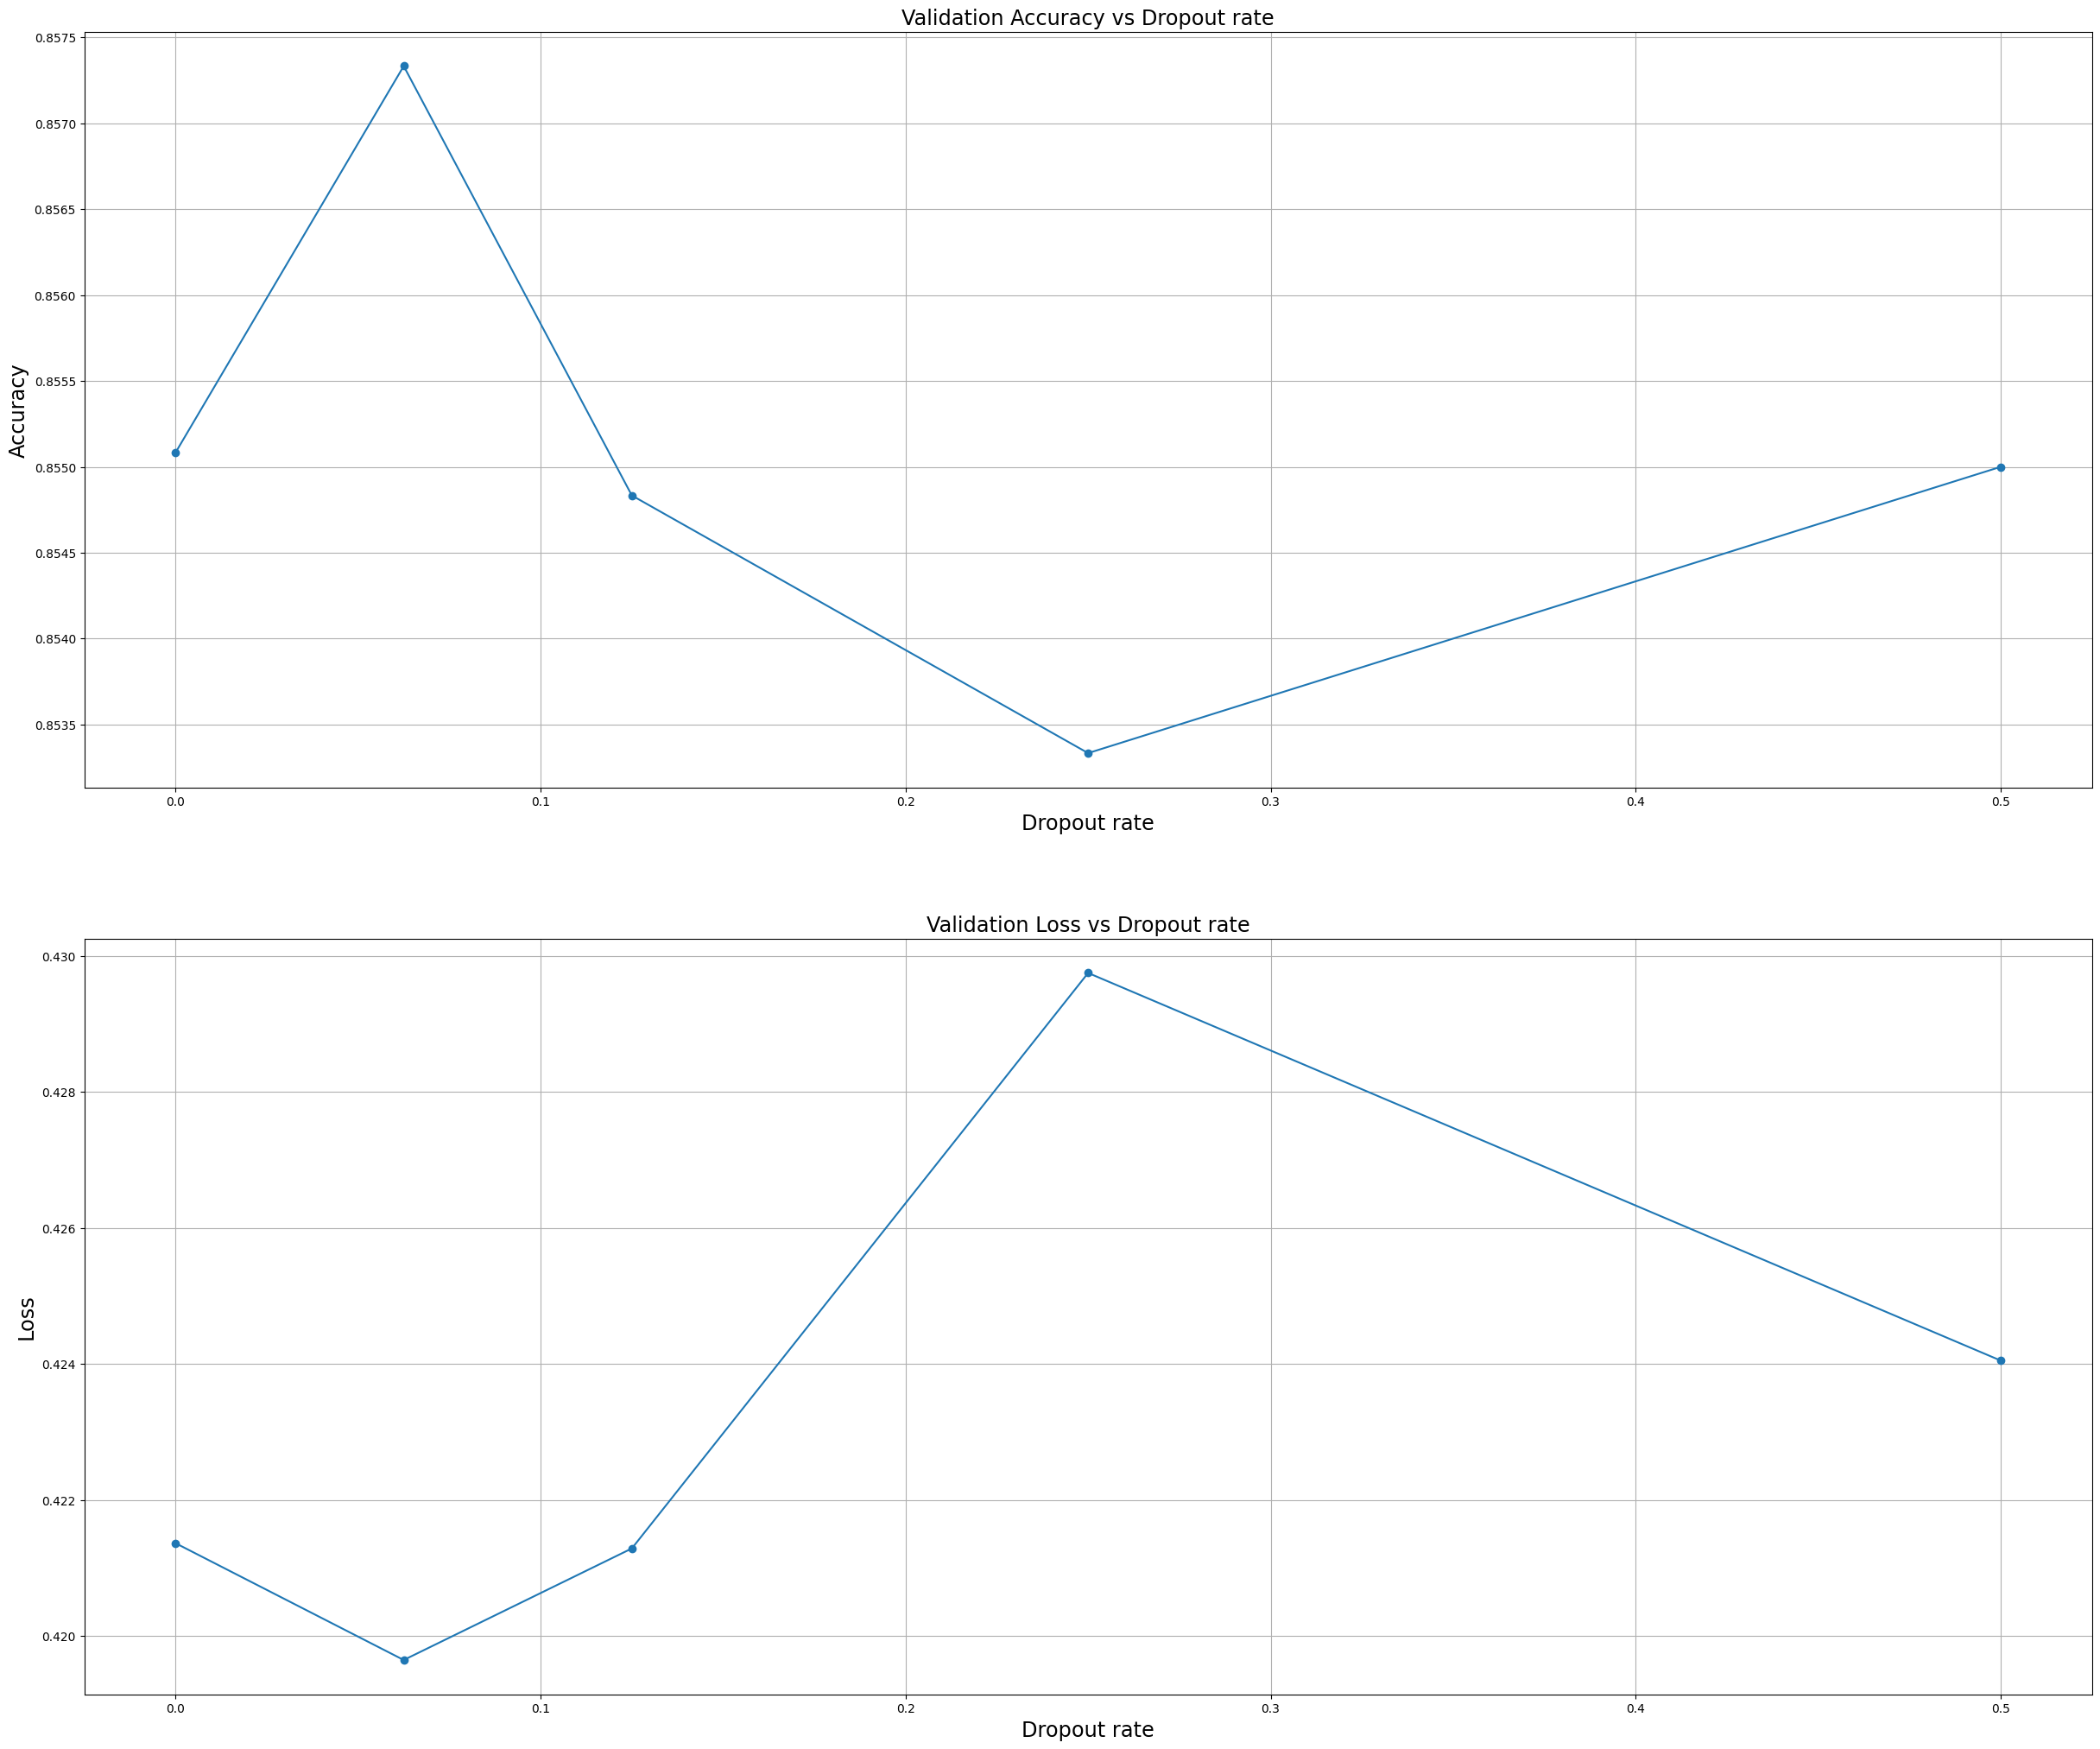

In [99]:
final_accuracies = [acc[-1] for acc in accuracies_dr]
final_losses = [loss[-1] for loss in losses_dr]

# Plotting accuracies
f, axis = plt.subplots(2, 1, figsize=(30, 25))
axis[0].plot(dropout_rate, final_accuracies, marker = 'o')
axis[0].set_xlabel('Dropout rate', fontsize='xx-large')
axis[0].set_ylabel('Accuracy', fontsize='xx-large')
axis[0].set_title('Validation Accuracy vs Dropout rate', fontsize='xx-large')
#axis[0].set_xscale('log')
axis[0].grid()

# Plotting losses
axis[1].plot(dropout_rate, final_losses, marker = 'o')
axis[1].set_xlabel('Dropout rate', fontsize='xx-large')
axis[1].set_ylabel('Loss', fontsize='xx-large')
axis[1].set_title('Validation Loss vs Dropout rate', fontsize='xx-large')
#axis[1].set_xscale('log')
axis[1].grid()

plt.show()

We do not have internal layers in the softmax regression so having a dropout layer should not produce any difference. See that the curves are in the same order, the differences are highlited because of the scale.

### Batch normalization

In [100]:
batch_normalization = [False, True]

accuracies_bn = []
losses_bn = []
histories_bn = []
for bn in batch_normalization:
    K.clear_session()
    model_bn = hp.classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 0,
                                    hidden_layers_units = [0],
                                    hidden_activation = 'sigmoid',
                                    kernel_initializer= 'random_normal',
                                    dropout_rate = 0.0,
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=bn,
                                    lr = 0.001,
                                    decay = 0,
                                    out_softmax = True,
                                    optimizer = Adam)
    model_trained_bn = model_bn.fit(    x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=128,
                                  verbose=0,
                                  validation_data = (x_val, y_val_categorical),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )
    accuracies_bn.append(model_trained_bn.history['val_accuracy'])
    losses_bn.append(model_trained_bn.history['val_loss'])
    histories_bn.append(model_trained_bn.history)


Epoch 40: early stopping
Epoch 31: early stopping


Max accuracy: 0.859666645526886 at batch normalization = False
Min loss: 0.41004204750061035 at batch normalization = False


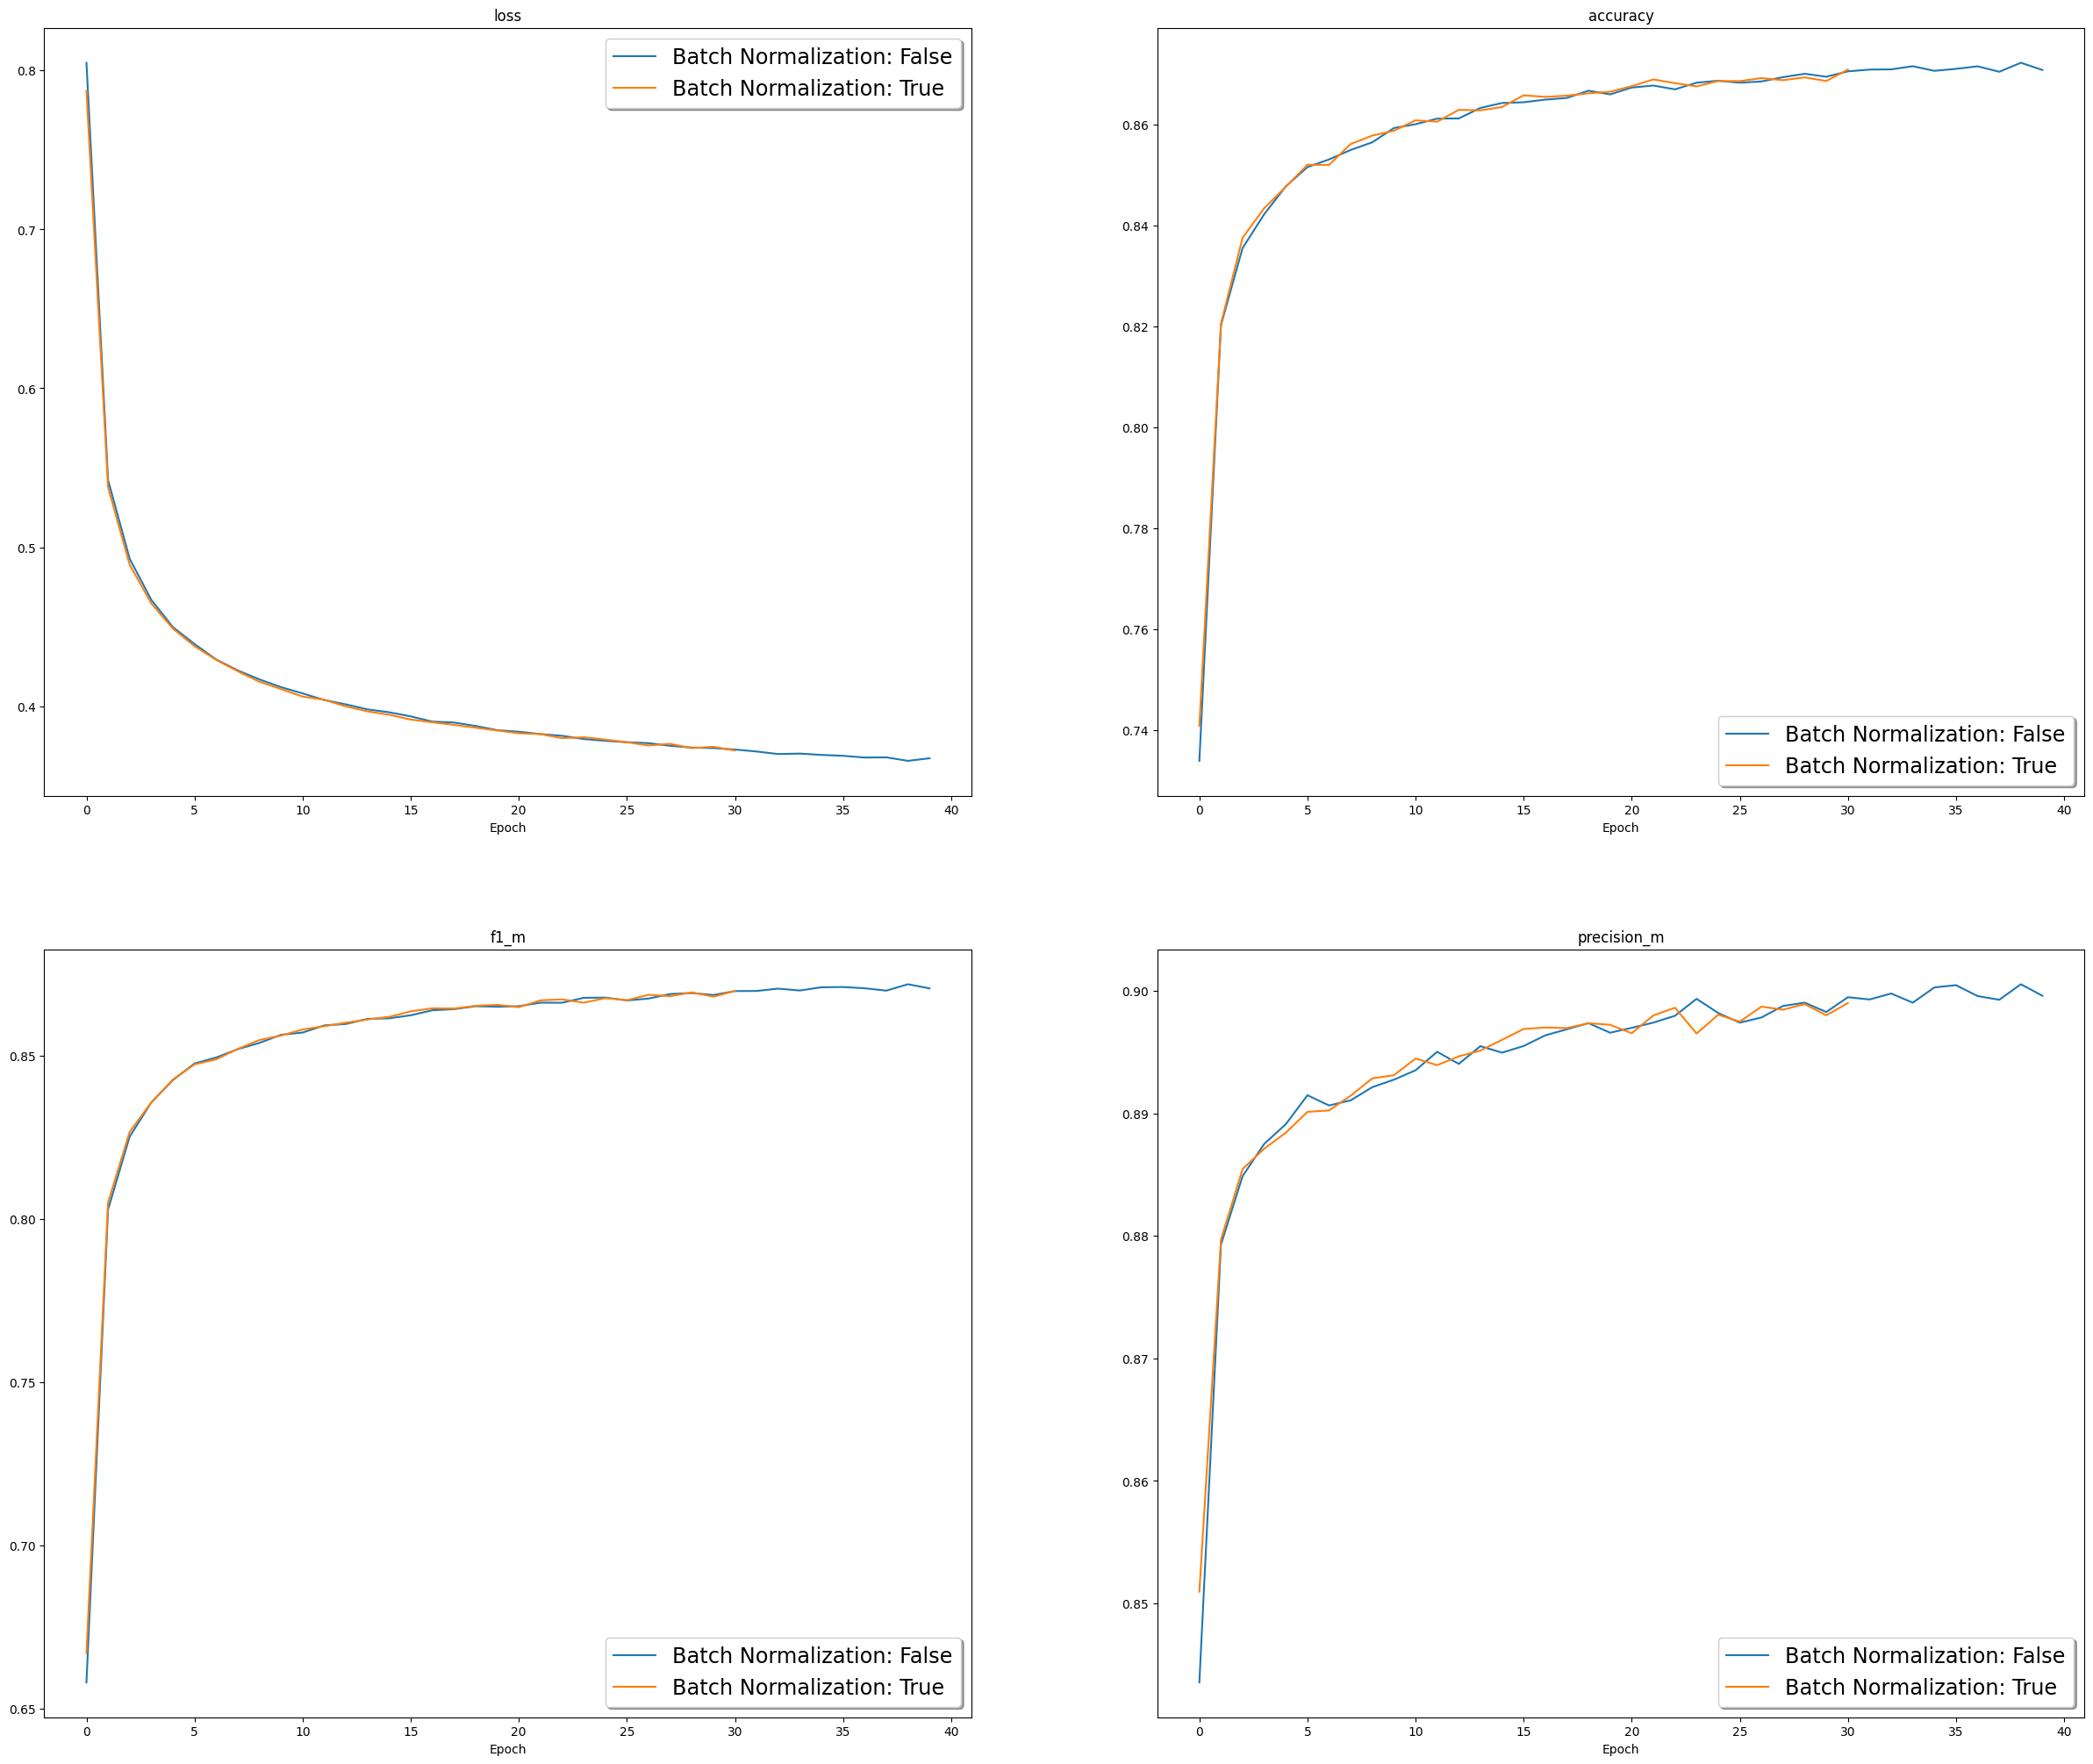

In [103]:
accuracies_array = np.array(accuracies_bn, dtype=object)
losses_array = np.array(losses_bn, dtype=object)

print("Max accuracy:", np.max(np.max(accuracies_array)), "at batch normalization =", batch_normalization[np.argmax(np.argmax(accuracies_array))])
print("Min loss:", np.min(np.max(losses_array)), "at batch normalization =", batch_normalization[np.argmin(np.argmax(losses_array))])

f, axis = plt.subplots(2, 2, figsize=(30, 25))
k = 0
for i in range(2):
    for j in range(2):
      for bn in range(len(batch_normalization)):
        axis[i,j].plot(histories_bn[bn][metrics[k][0][0]], label=f'Batch Normalization: {batch_normalization[bn]}')
        axis[i,j].grid()
        axis[i,j].set_xlabel('Epoch')
        axis[i,j].legend(shadow=True, fontsize='xx-large')
        axis[i,j].set_title(metrics[k][0][1])
      k += 1
plt.show()

Kind of interesting that we get better results without a Batch Normalization. The differences are almost negligible though.

### Weigth Initialization


In [79]:
from keras.initializers import GlorotUniform, GlorotNormal, RandomNormal

In [86]:
weight_inits = [None, GlorotUniform(seed=42), GlorotNormal(seed=42),RandomNormal(0,1), RandomNormal(0,0.001)]

accuracies_wi = []
losses_wi = []
histories_wi = []
for wi in weight_inits:
    K.clear_session()
    model_wi = hp.classification_model(     x_train.shape,
                                    output_size = 10,
                                    hidden_layers_size = 0,
                                    hidden_layers_units = [0],
                                    hidden_activation = 'sigmoid',
                                    kernel_initializer= wi,
                                    dropout_rate = 0.0,
                                    regularizer = None,
                                    regularizer_rate = 0.001,
                                    bias_initializer = 'zeros',
                                    use_batch_normalization=True,
                                    lr = 0.001,
                                    decay = 0,
                                    out_softmax = True,
                                    optimizer = Adam)
    model_trained_wi = model_wi.fit(    x_train,
                                  y_sparse_train,
                                  epochs=512, batch_size=128,
                                  verbose=0,
                                  validation_data = (x_val, y_val_categorical),
                                  callbacks=[hp.callback_EarlyStopping()],
                                )
    accuracies_wi.append(model_trained_wi.history['val_accuracy'])
    losses_wi.append(model_trained_wi.history['val_loss'])
    histories_wi.append(model_trained_wi.history)


Epoch 47: early stopping
Epoch 47: early stopping
Epoch 46: early stopping
Epoch 48: early stopping
Epoch 50: early stopping


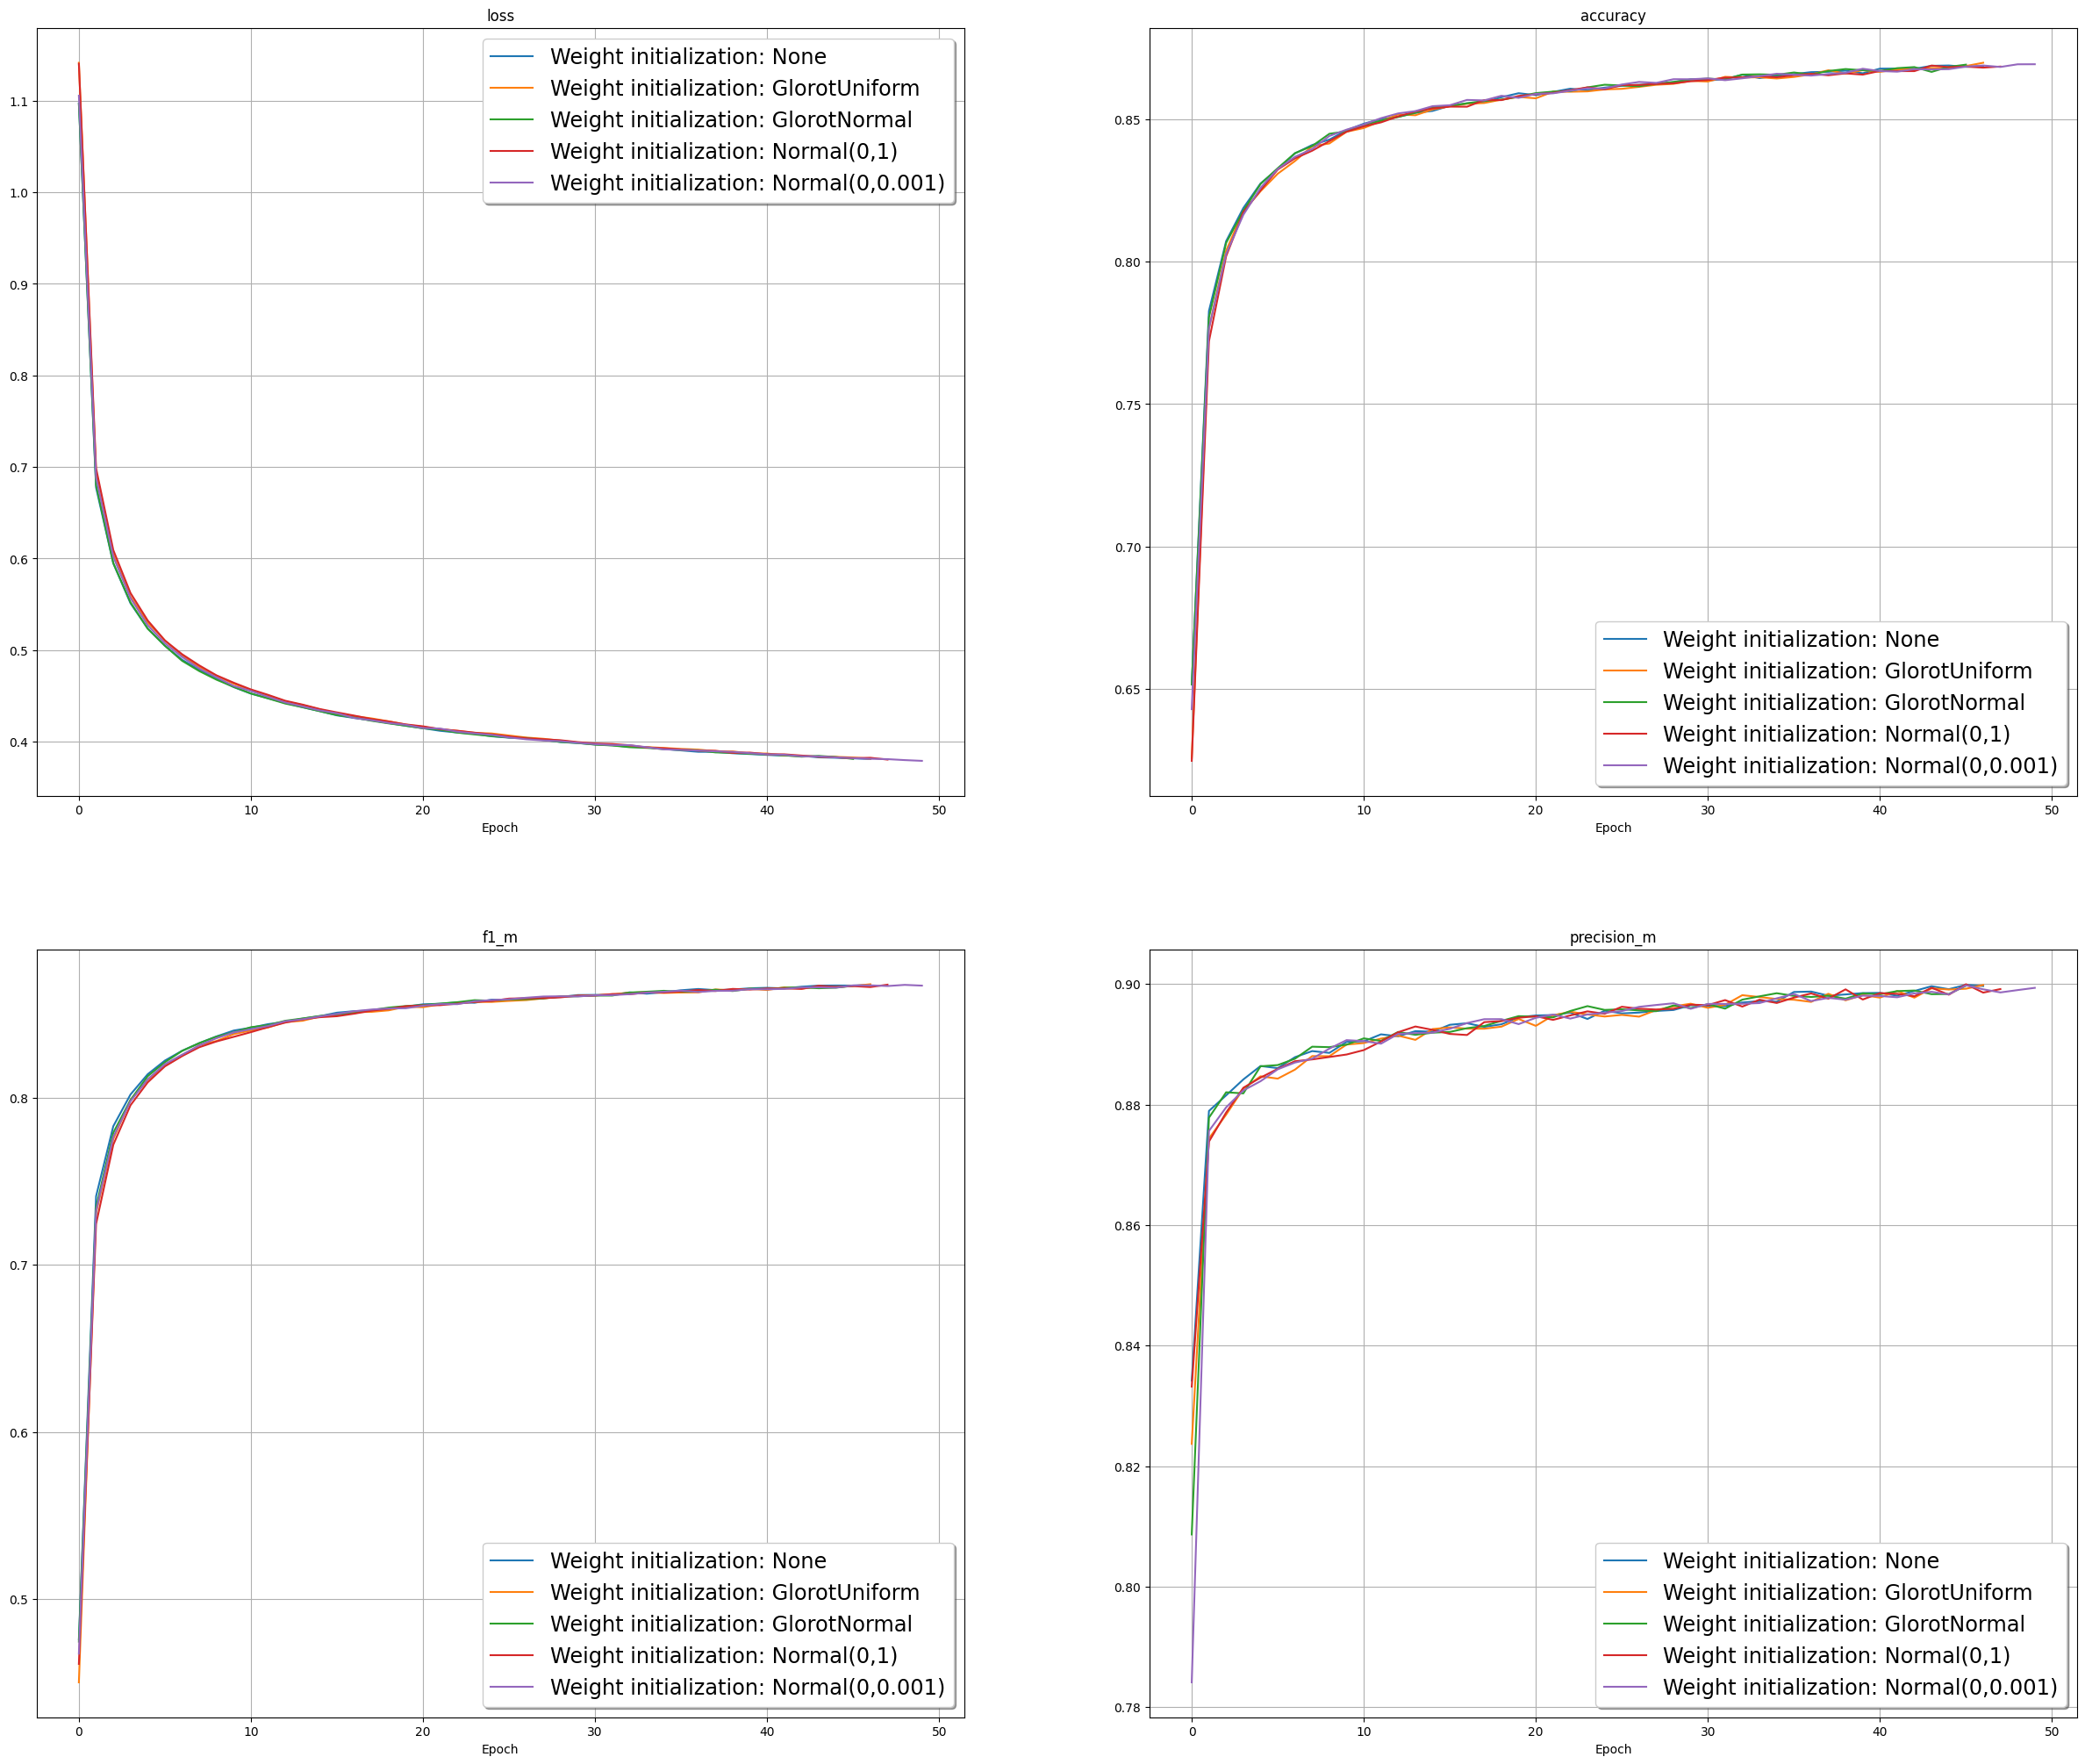

In [88]:
weight_init_names = ['None', 'GlorotUniform', 'GlorotNormal', 'Normal(0,1)', 'Normal(0,0.001)']

f, axis = plt.subplots(2, 2, figsize=(30, 25))
k = 0
for i in range(2):
    for j in range(2):
      for wi in range(len(weight_inits)):
        axis[i,j].plot(histories_wi[wi][metrics[k][0][0]], label=f'Weight initialization: {weight_init_names[wi]}')
        axis[i,j].grid()
        axis[i,j].set_xlabel('Epoch')
        axis[i,j].legend(shadow=True, fontsize='xx-large')
        axis[i,j].set_title(metrics[k][0][1])
      k += 1
plt.show()

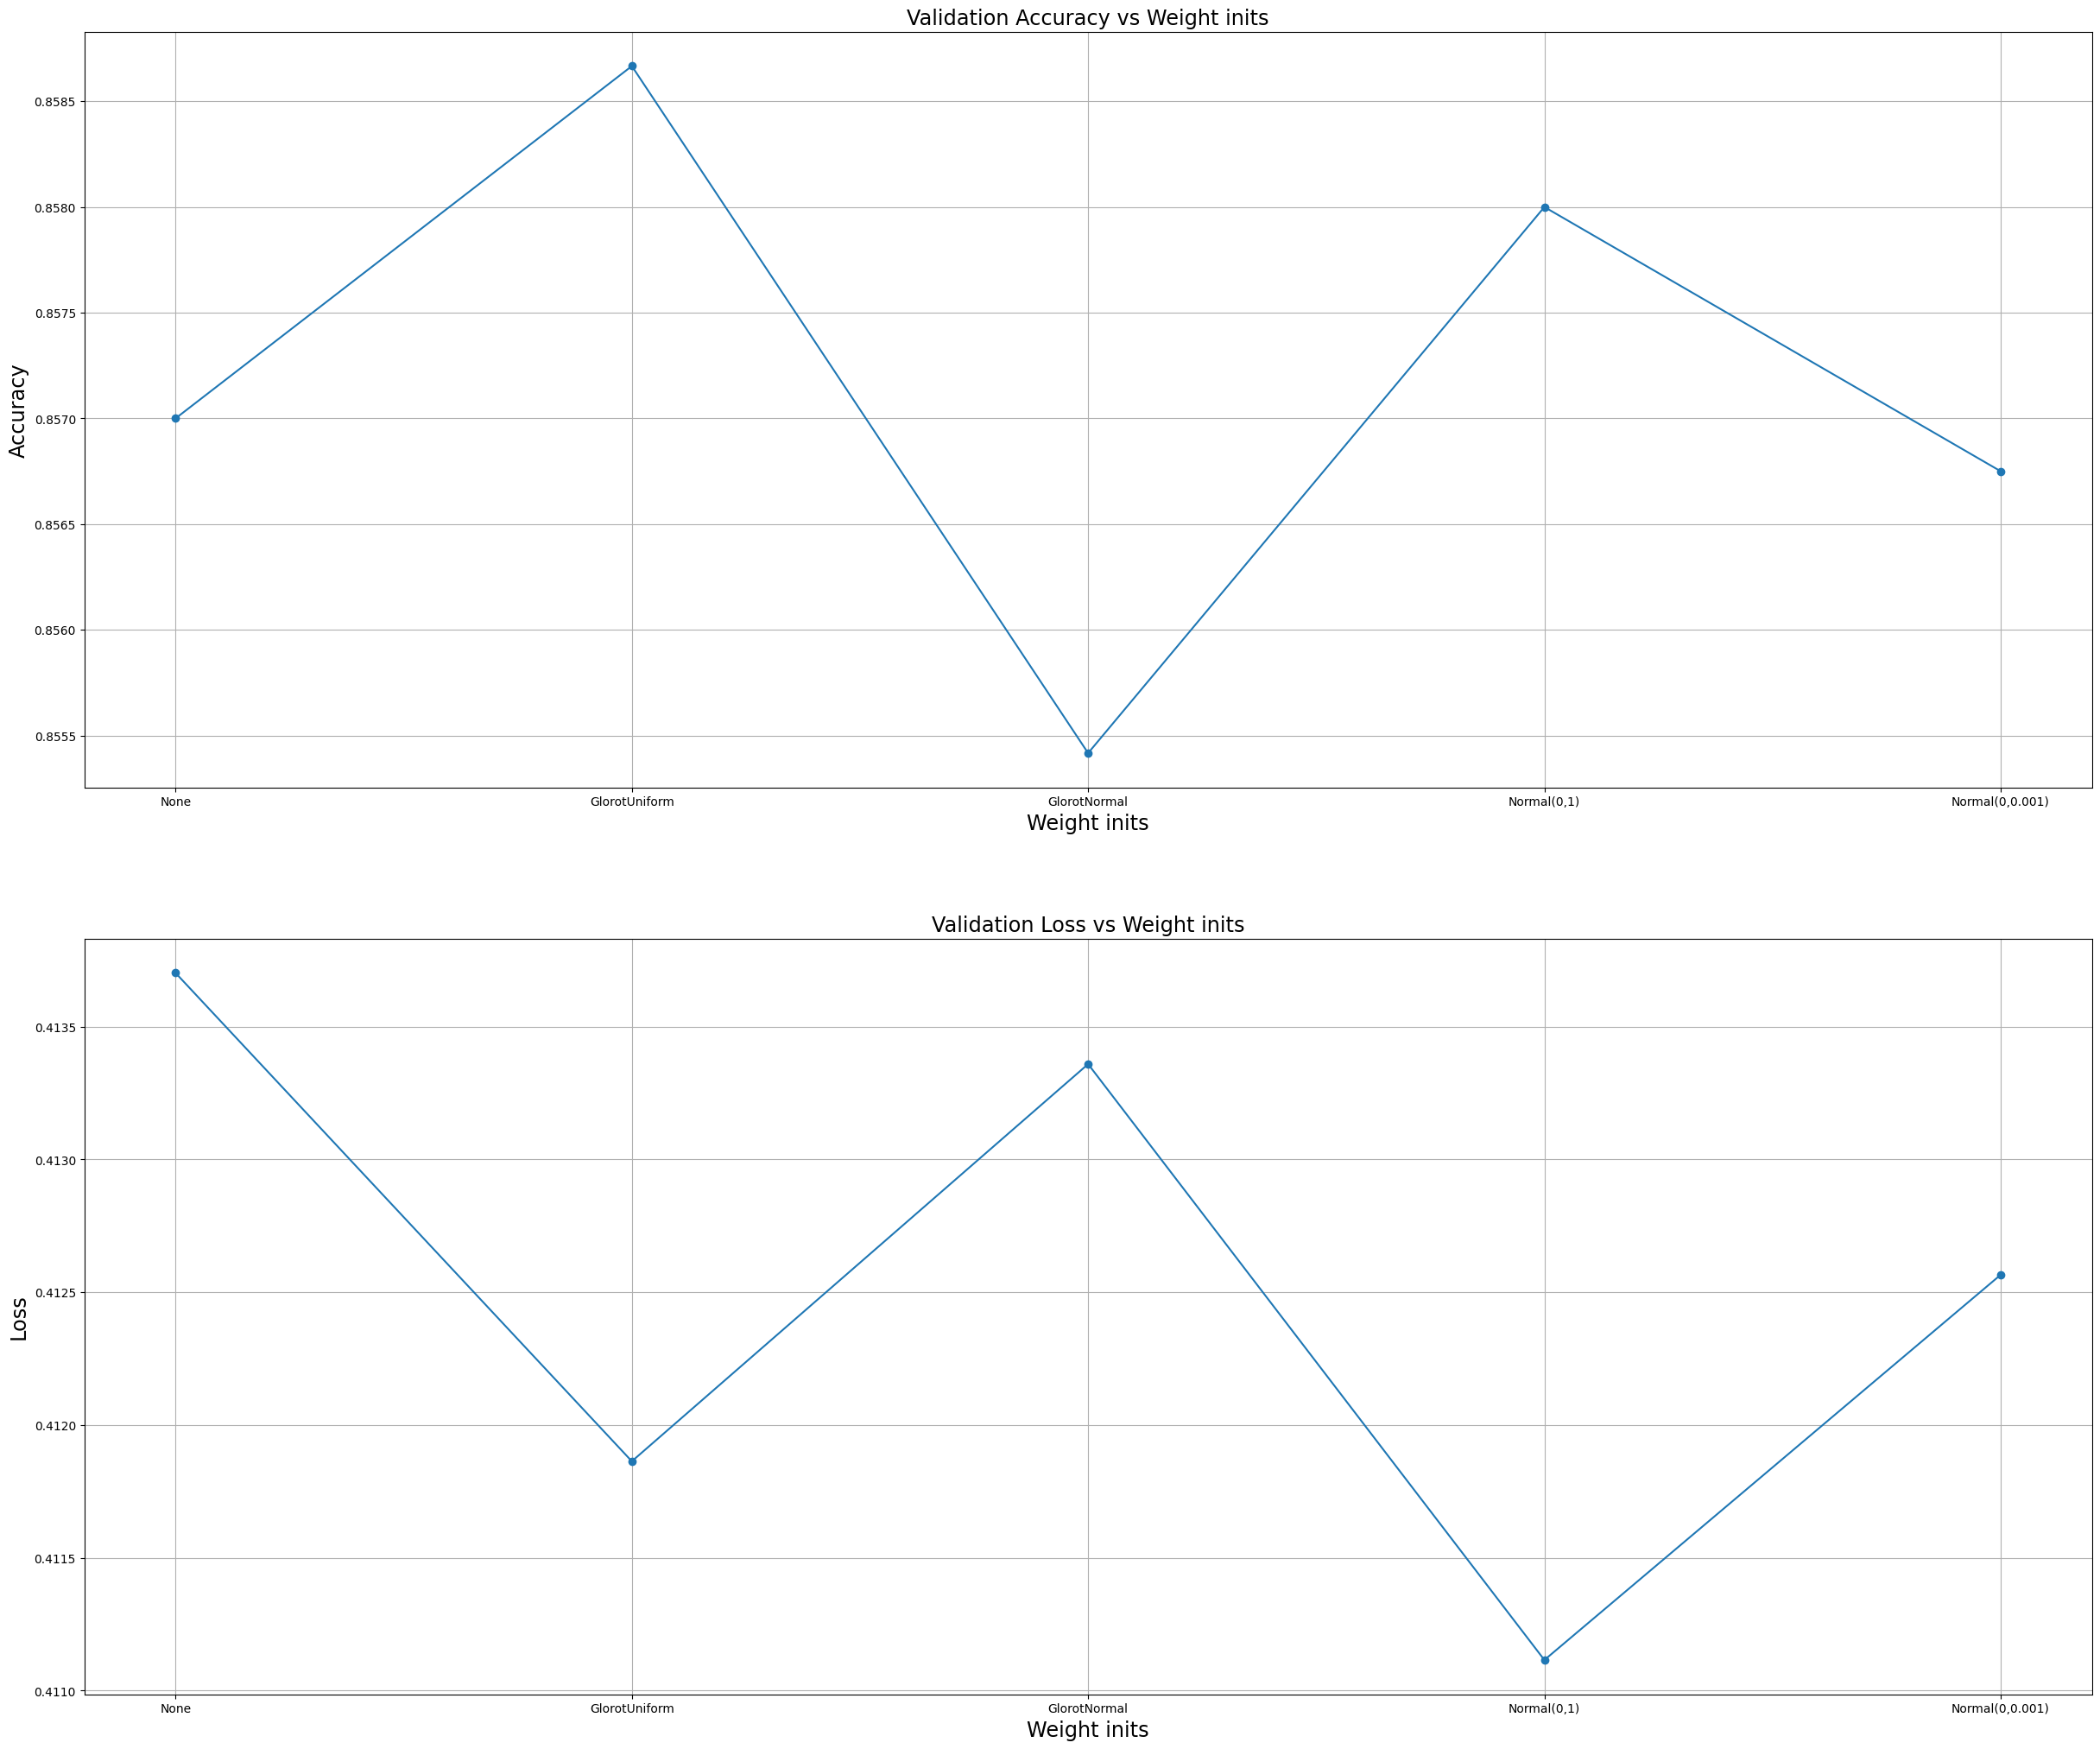

In [89]:
final_accuracies = [acc[-1] for acc in accuracies_wi]
final_losses = [loss[-1] for loss in losses_wi]

# Plotting accuracies
f, axis = plt.subplots(2, 1, figsize=(30, 25))
axis[0].plot(weight_init_names, final_accuracies, marker = 'o')
axis[0].set_xlabel('Weight inits', fontsize='xx-large')
axis[0].set_ylabel('Accuracy', fontsize='xx-large')
axis[0].set_title('Validation Accuracy vs Weight inits', fontsize='xx-large')
axis[0].grid()

# Plotting losses
axis[1].plot(weight_init_names, final_losses, marker = 'o')
axis[1].set_xlabel('Weight inits', fontsize='xx-large')
axis[1].set_ylabel('Loss', fontsize='xx-large')
axis[1].set_title('Validation Loss vs Weight inits', fontsize='xx-large')
axis[1].grid()

plt.show()

See that we get different values from each iteration. We will use Normal(0.1) for following trainings as it shows a consistent behaviour.

The neural network needs to start with some weights and then iteratively update them to better values. The term kernel_initializer is a fancy term for which statistical distribution or function to use for initialising the weights. In case of statistical distribution, the library will generate numbers from that statistical distribution and use as starting weights.
https://datascience.stackexchange.com/questions/37378/what-are-kernel-initializers-and-what-is-their-significance